In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [1]:
%matplotlib inline

In [23]:
figure_name = 'figures/fig_5_timing_'

In [73]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from skimage import measure

from mpl_toolkits.mplot3d import Axes3D

import dill

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
# print(mpl.rcParams.keys())

In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 2.3 # -> 23ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [6]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q



# Input

In [ ]:
gbc_offsets = np.array(np.arange(-400,300,5))
#gbc_input_intensities = np.array([1.0,2.5,5.0,7.5,10.0])
# sbc_input_intensities = np.array([0.5])
# gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
gbc_input_intensities = np.linspace(0,1,41)
sbc_input_intensities = np.linspace(1,0,41)


# store the solutions
q_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))

for l in range(len(gbc_offsets)):
    for k in range(len(gbc_input_intensities)):



        ############################################################
        #                       Inputs                             #
        ############################################################

        
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))
        
        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 600
        gbc_input_duration = 300
        gbc_input_offset = gbc_offsets[l]
        gbc_center_frequencyBand = 2
        gbc_input_strength = gbc_input_intensities[k]
        
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
#         gbc_gauss_mask = gauss(np.arange(gbc_input_duration),gbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


        s_gbc_all[gbc_input_onset+gbc_input_offset:gbc_input_onset+gbc_input_offset+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength 
        s_gbc_all[gbc_input_onset+gbc_input_offset+500:gbc_input_onset+gbc_input_offset+500+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength 
        s_gbc_all[gbc_input_onset+gbc_input_offset+1000:gbc_input_onset+gbc_input_offset+1000+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength 
#         s_gbc_all[gbc_input_onset+gbc_input_offset+1200:gbc_input_onset+gbc_input_offset+1200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask

        sigma_neighbor = 1.0
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma_neighbor)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 600
        sbc_input_duration = 300
        sbc_input_offset =  0
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]

        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
#         sbc_gauss_mask = gauss(np.arange(sbc_input_duration),sbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


#         s_sbc_all[sbc_input_onset+sbc_input_offset:sbc_input_onset+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength 
        s_sbc_all[sbc_input_onset+500+sbc_input_offset:sbc_input_onset+500+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength 
#         s_sbc_all[sbc_input_onset+1000+sbc_input_offset:sbc_input_onset+1000+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength 
#         s_sbc_all[sbc_input_onset-200+sbc_input_offset:sbc_input_onset-200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask

        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma_neighbor)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # Convolve with gauss curve to build a temporal ramp
        gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,2)
        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
        gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,2)
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')



        ############################################################
        #                      Simulation                          #
        ############################################################
        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                delay_factor = 20
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel)       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel)       
                
                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)
    print(l)

0


In [24]:
# dill.dump_session('figure_5_timing')
dill.load_session('figure_5_timing')

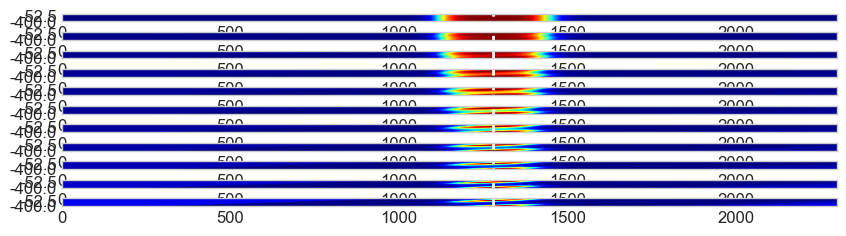

In [26]:
# # ############################################################
# # #                       Plotting                           #
# # ############################################################


probing_time = 1280


fig = plt.figure()
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
#plt.suptitle(stri,fontsize=16)
#r = r_all[:,:,500:900,3]
r = r_all[:,:,:,3]


for i in range(0,r.shape[1]-20,2):
    ax1 = plt.subplot2grid((r.shape[1], 1), (i, 0), colspan=2)
    ax1.pcolormesh(g_r_out(r[:,i,:]),cmap='jet')
    ax1.axvline(x=probing_time, ymin=-100.0, ymax=100.0, color='white',linestyle='--')    

#     tmp = gbc_offsets[::int((len(gbc_offsets)/len(ax1.get_yticks())))+5]
    ax1.set_yticklabels(np.linspace(gbc_offsets[0],gbc_offsets[-1],len(ax1.get_yticks())))
#     ax1.set_xticklabels(ax1.get_xticks()/100)
#     plt.tight_layout()

plt.show()


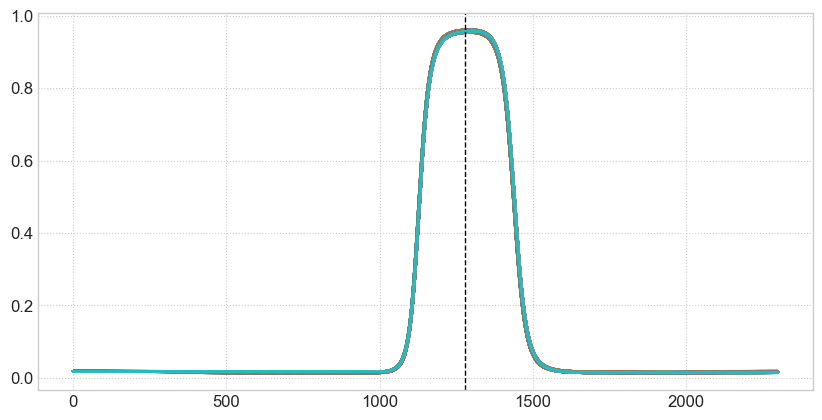

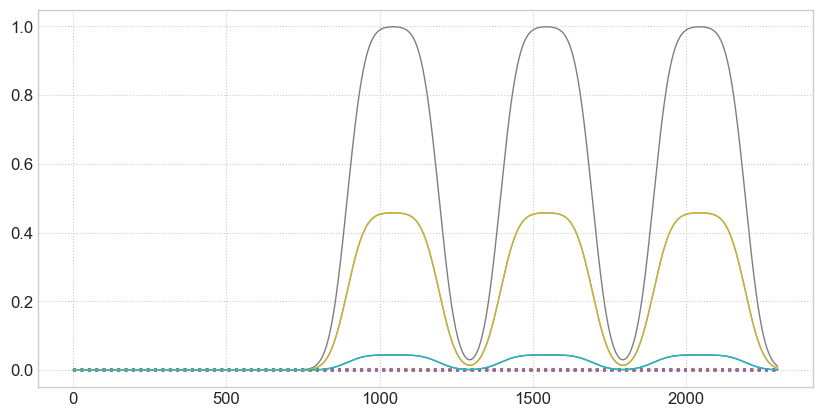

In [27]:
probing_time = 1280

fig = plt.figure()
ax1 = fig.add_subplot(111)
# print(gbc_offsets[6])
ax1.plot(g_r_out(r[:,1,:]).T)
ax1.axvline(x=probing_time, ymin=0.0, ymax=1.0, color='black',linestyle='--',linewidth = 1)    

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(s_sbc_all,linestyle=':')
ax1.plot(s_gbc_all,linewidth= 1)


plt.show()

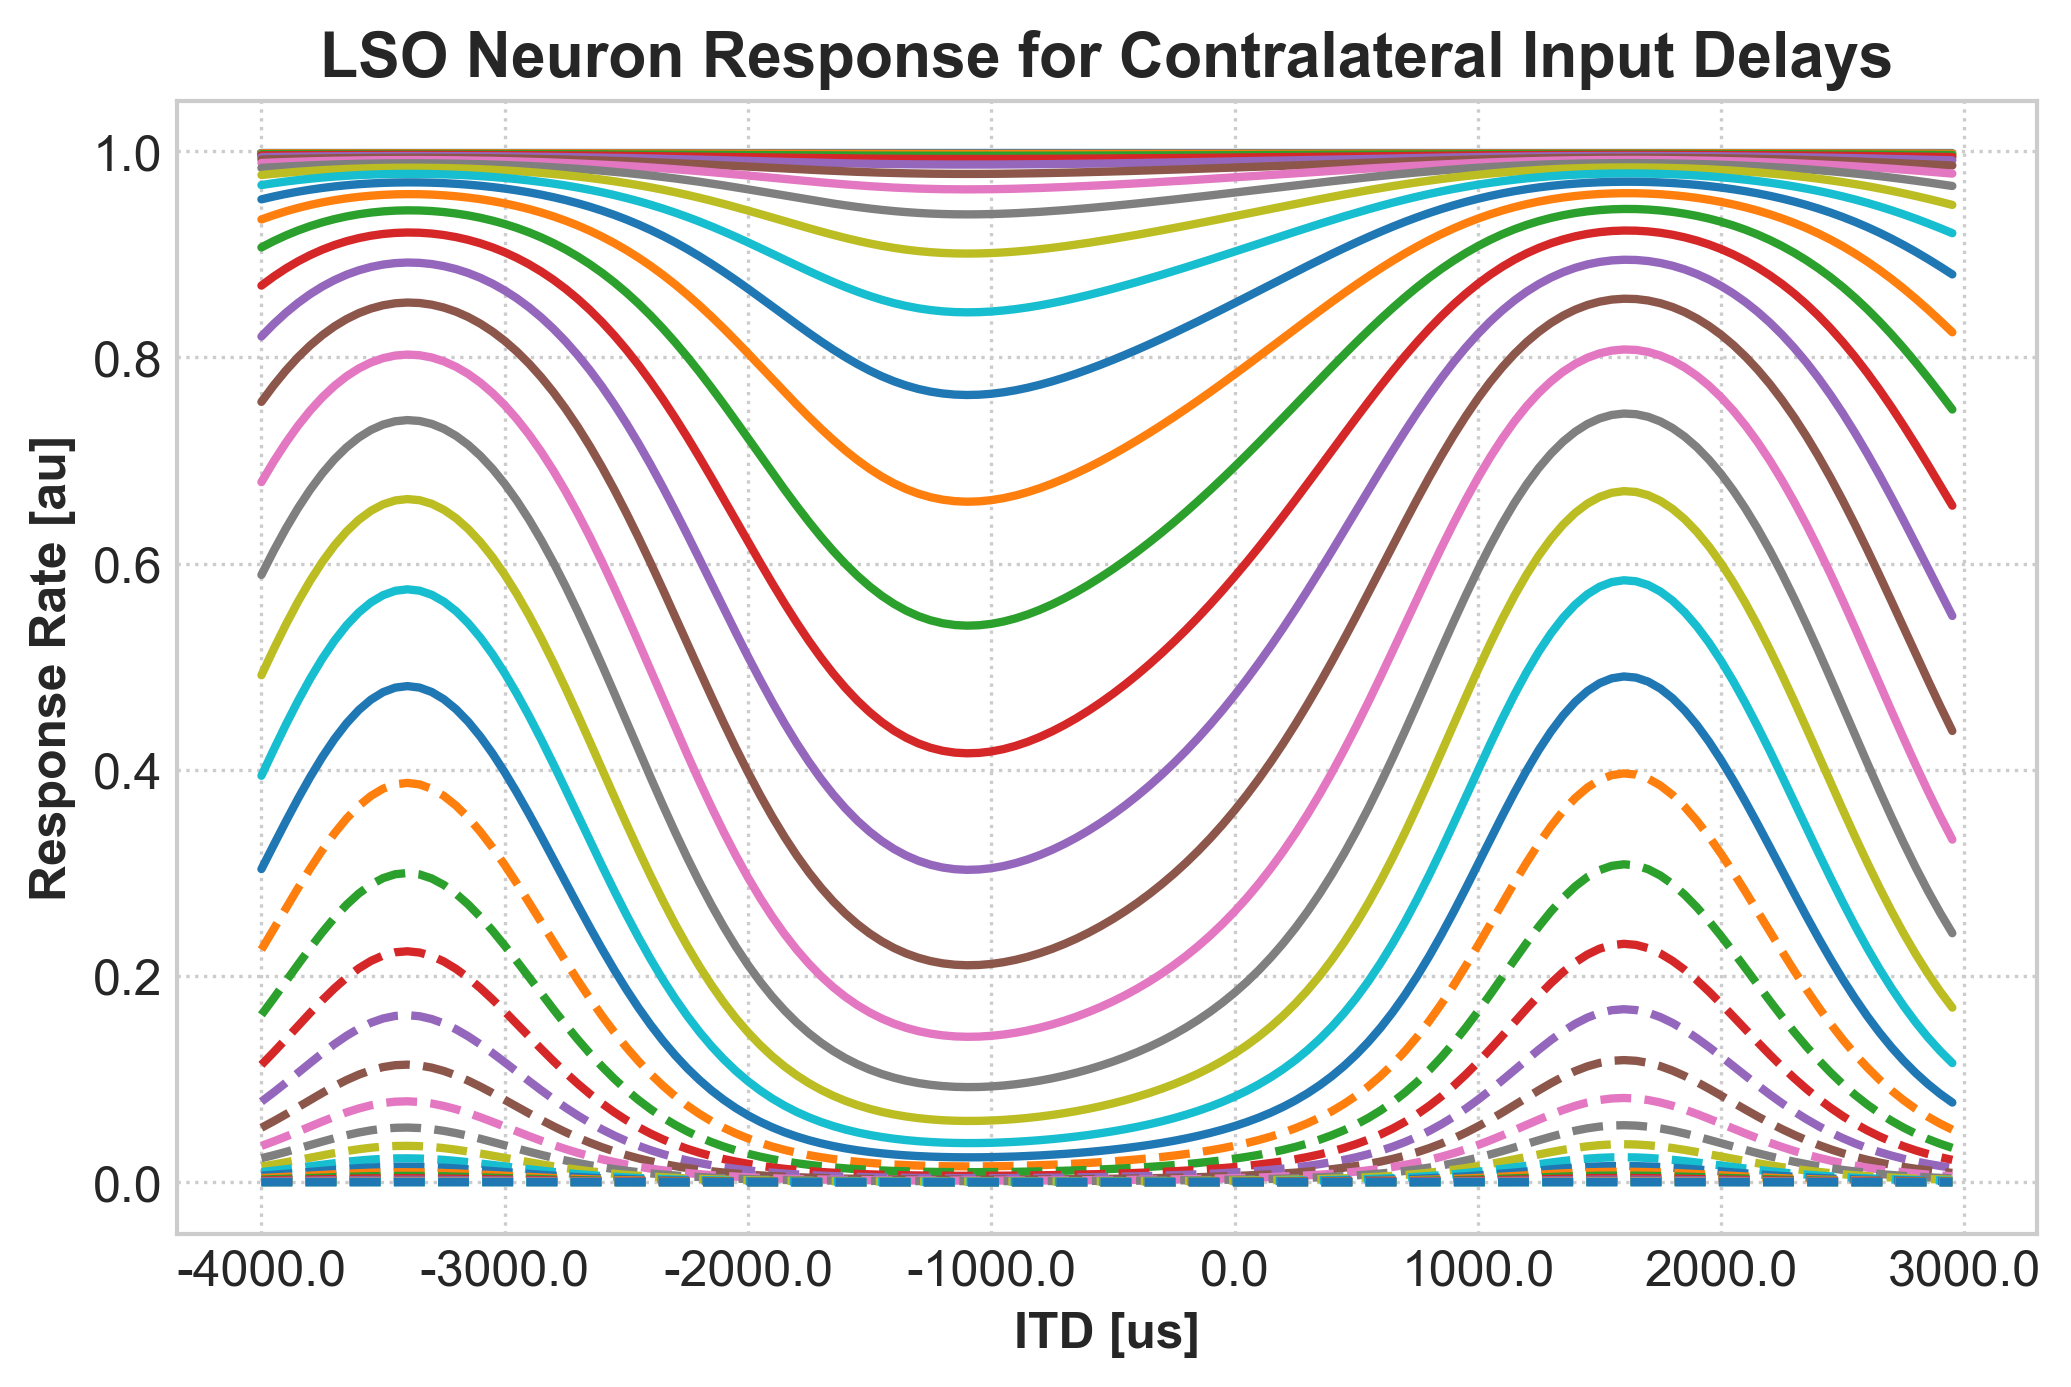

In [74]:
fig = plt.figure()

# probing_time = 1650

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]

ax1 = fig.add_subplot(111)
for i in range(r.shape[1]):
    level_diff = sbc_input_intensities[i] - gbc_input_intensities[i]
    if level_diff < 0:
        line_style = '--'
    else:
        line_style = '-'
    ax1.plot(gbc_offsets[:],r[:,i,probing_time],linestyle = line_style,label='Input Intensity Difference = {0:.2f}'.format(level_diff))
#     ax1.plot(-gbc_offsets[:],np.max(r[:,i,:],axis=1),linestyle = line_style,label='Input Intensity Difference = {0:.2f}'.format(level_diff))

    
plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ITD [us]')
plt.ylabel('Response Rate [au]')
ax1.set_xticklabels(ax1.get_xticks()*10)
# lgd = plt.legend(loc=(1.04,0))

# plt.savefig(figure_name + 'timing_curves.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'timing_curves.pdf',bbox_inches='tight')


plt.show()


0.0


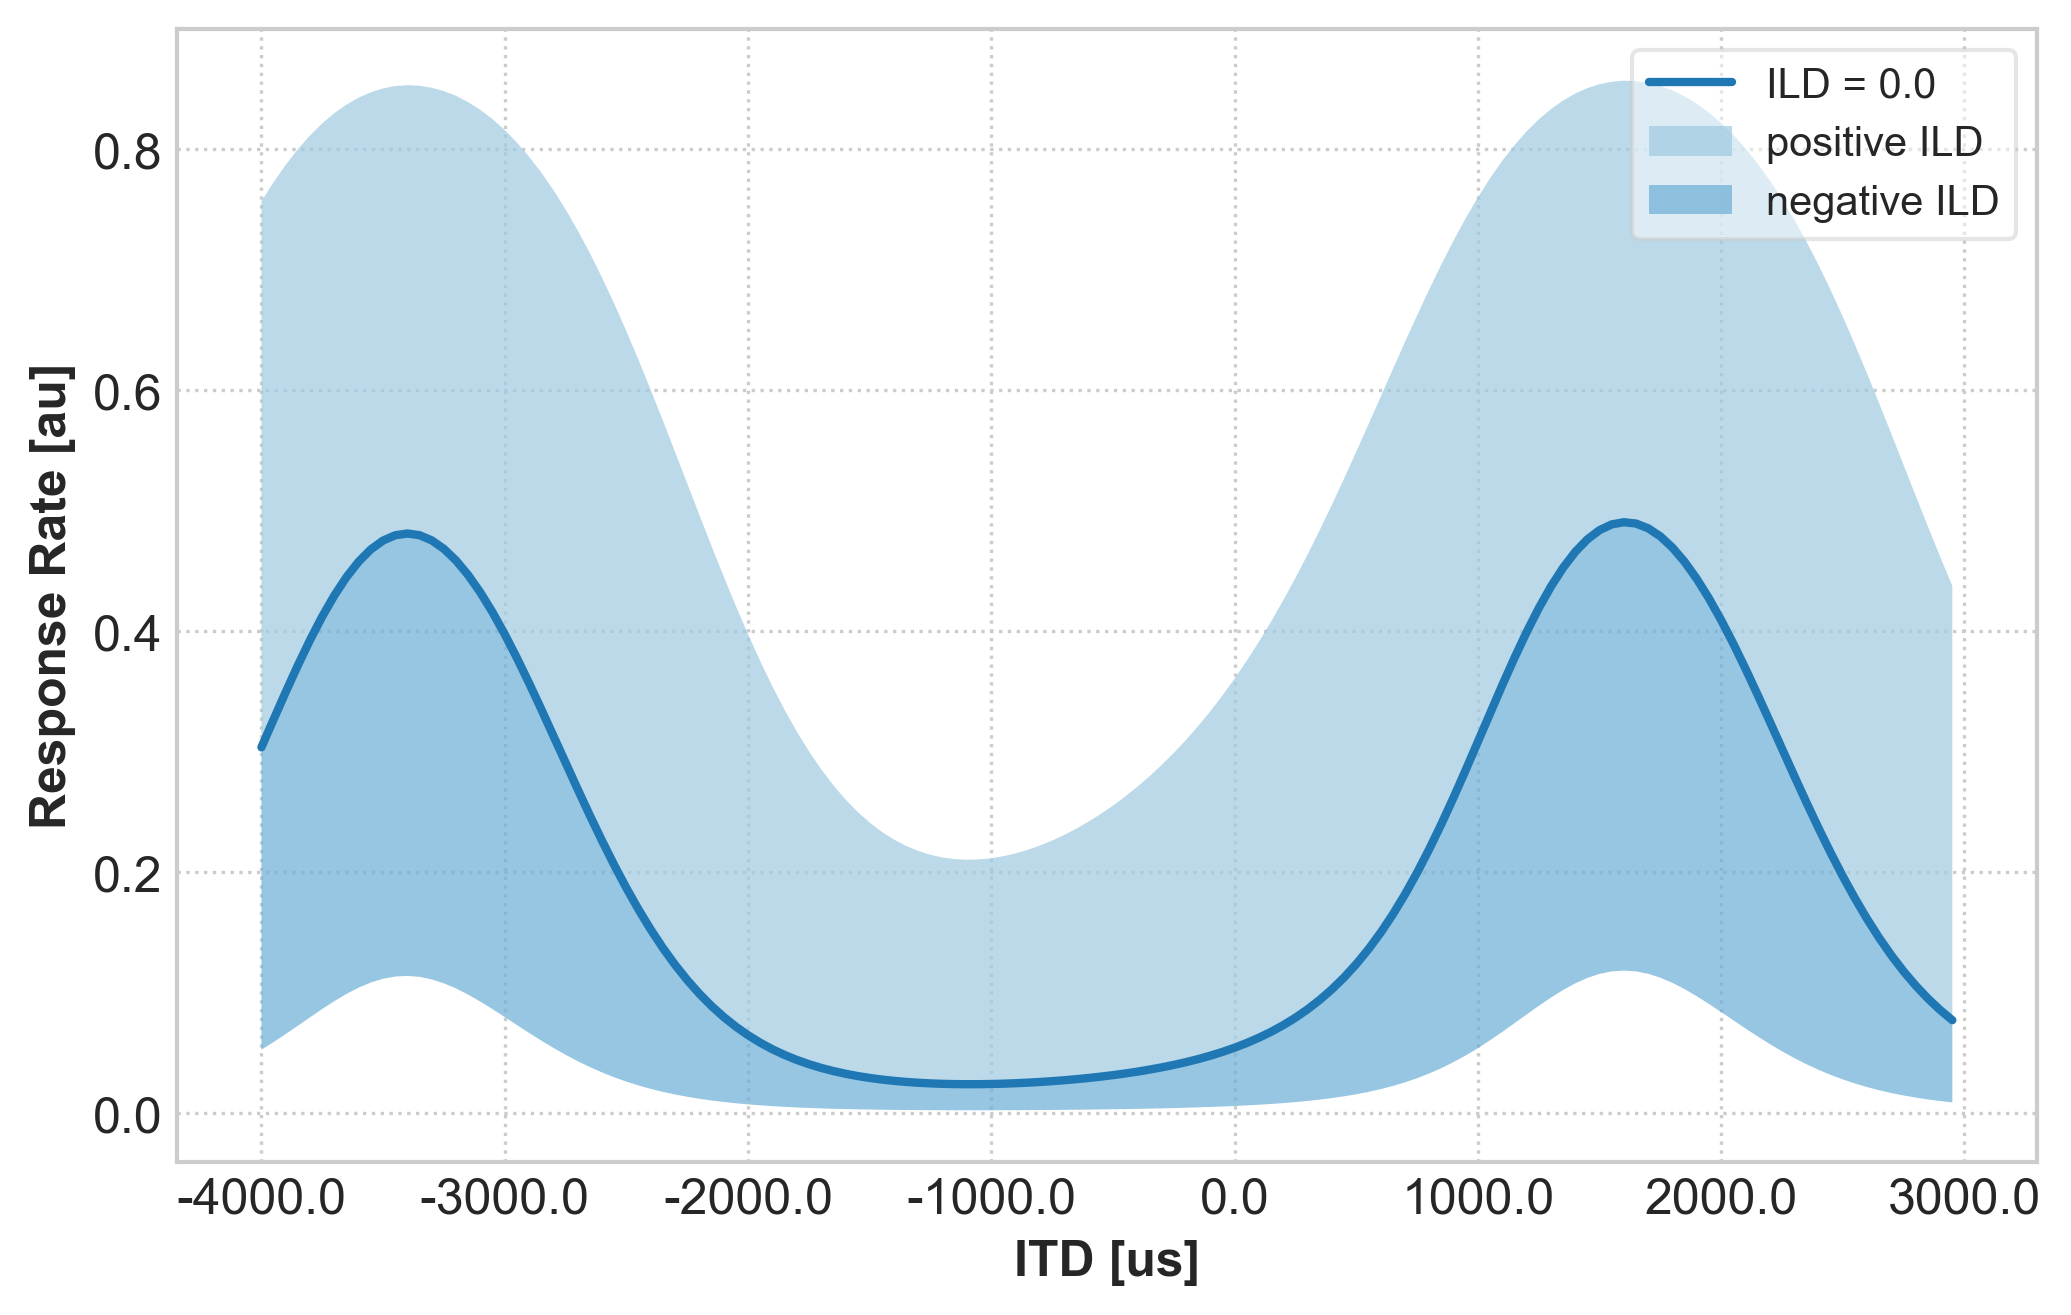

In [109]:
fig = plt.figure()

gbc_input_offset = -gbc_input_offset

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
level_diff = sbc_input_intensities - gbc_input_intensities

print(level_diff[20])
ax1 = fig.add_subplot(111)
# we do not have values for 0 ilds therefore we need to interpolate them
zero_ild_plot_values = np.mean([r[:,20,probing_time],r[:,20,probing_time]],0)
plot_handler = ax1.plot(gbc_offsets[:],zero_ild_plot_values,label='ILD = {0:.1f}'.format(0.0))

fill_handler_2 = ax1.fill_between(gbc_offsets[:], r[:,15,probing_time],zero_ild_plot_values, facecolor='#9ecae1', alpha=0.7,label='positive ILD')
fill_handler_1 = ax1.fill_between(gbc_offsets[:], zero_ild_plot_values, r[:,25,probing_time], facecolor='#6baed6', alpha=0.7,label='negative ILD')

    
# plt.title('LSO Neuron Response for Ipsilateral Input Delays')
plt.xlabel('ITD [us]')
plt.ylabel('Response Rate [au]')
ax1.set_xticklabels(ax1.get_xticks()*10)

# ax1.axvline(x=60,linestyle='--',color='grey',alpha = 0.5, linewidth = 1.25)
# ax1.axvline(x=-60,linestyle='--',color='grey',alpha = 0.5, linewidth = 1.25)

# set better order of legend labels
# hh=[fill_handler_1,fill_handler_2,plot_handler[0]]
# plt.legend([fill_handler_1,fill_handler_2,plot_handler[0]],[H.get_label() for H in hh])


lgd = plt.legend()

plt.savefig(figure_name + 'timing_curves_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'timing_curves_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'timing_curves_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

a = sbc_input_intensities - gbc_input_intensities
# print(a[6],a[13])

In [30]:
# fig = plt.figure()

# r = (r_all[:,:,:,sbc_center_frequencyBand])
# q = q_all[:,:,:,sbc_center_frequencyBand]
# ax1 = fig.add_subplot(111)
# # for i in range(28,r.shape[0]-10,2):
# for i in range(0,r.shape[0],1):
#     for j in range(0,r.shape[1]):
    
#         if gbc_offsets[i] < 0:
#             line_style = '--'
#             line_width = 2
#         elif gbc_offsets[i] == 0:
#             line_style = '-'
#             line_width = 4
#             print(i)
#         else:
#             line_style = ':'
#             line_width = 2
#         ax1.plot(r[i,j,:],linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))
#     #     ax1.plot((sbc_input_intensities-gbc_input_intensities),np.max(r[i,:,:],axis=1),linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))

    
# # ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[10,:,500], r[r.shape[0]-29,:,500], facecolor='yellow', alpha=0.5,
# #                 label='')
# # ax1.set_xticklabels(ax1.get_xticks()*-1)
# plt.title('LSO Neuron Response for Contralateral Input Delays')
# plt.xlabel('ILD [dB]')
# # ax1.set_xticklabels(ax1.get_xticks()*100)
# plt.ylabel('Response Rate [au]')
# # ax1.invert_xaxis()
# # lgd = plt.legend(loc=(1.04,0))

# # plt.savefig(figure_name + 'ild.svg', bbox_inches='tight')
# # plt.savefig(figure_name + 'ild.pdf', bbox_inches='tight')


# plt.show()

80


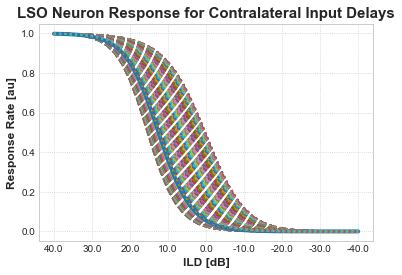

In [38]:
fig = plt.figure()

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)
# for i in range(28,r.shape[0]-10,2):
for i in range(0,r.shape[0],1):
    
    if gbc_offsets[i] < 0:
        line_style = '--'
        line_width = 2
    elif gbc_offsets[i] == 0:
        line_style = '-'
        line_width = 4
        print(i)
    else:
        line_style = ':'
        line_width = 2
    ax1.plot((sbc_input_intensities-gbc_input_intensities),r[i,:,probing_time],linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))
#     ax1.plot((sbc_input_intensities-gbc_input_intensities),np.max(r[i,:,:],axis=1),linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))


l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)
# ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[10,:,500], r[r.shape[0]-29,:,500], facecolor='yellow', alpha=0.5,
#                 label='')
# ax1.set_xticklabels(ax1.get_xticks()*-1)
plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ILD [dB]')
# ax1.set_xticklabels(ax1.get_xticks()*100)
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
# lgd = plt.legend(loc=(1.04,0))

plt.savefig(figure_name + 'ild.svg', bbox_inches='tight')
plt.savefig(figure_name + 'ild.pdf', bbox_inches='tight')


plt.show()

In [32]:
%matplotlib inline

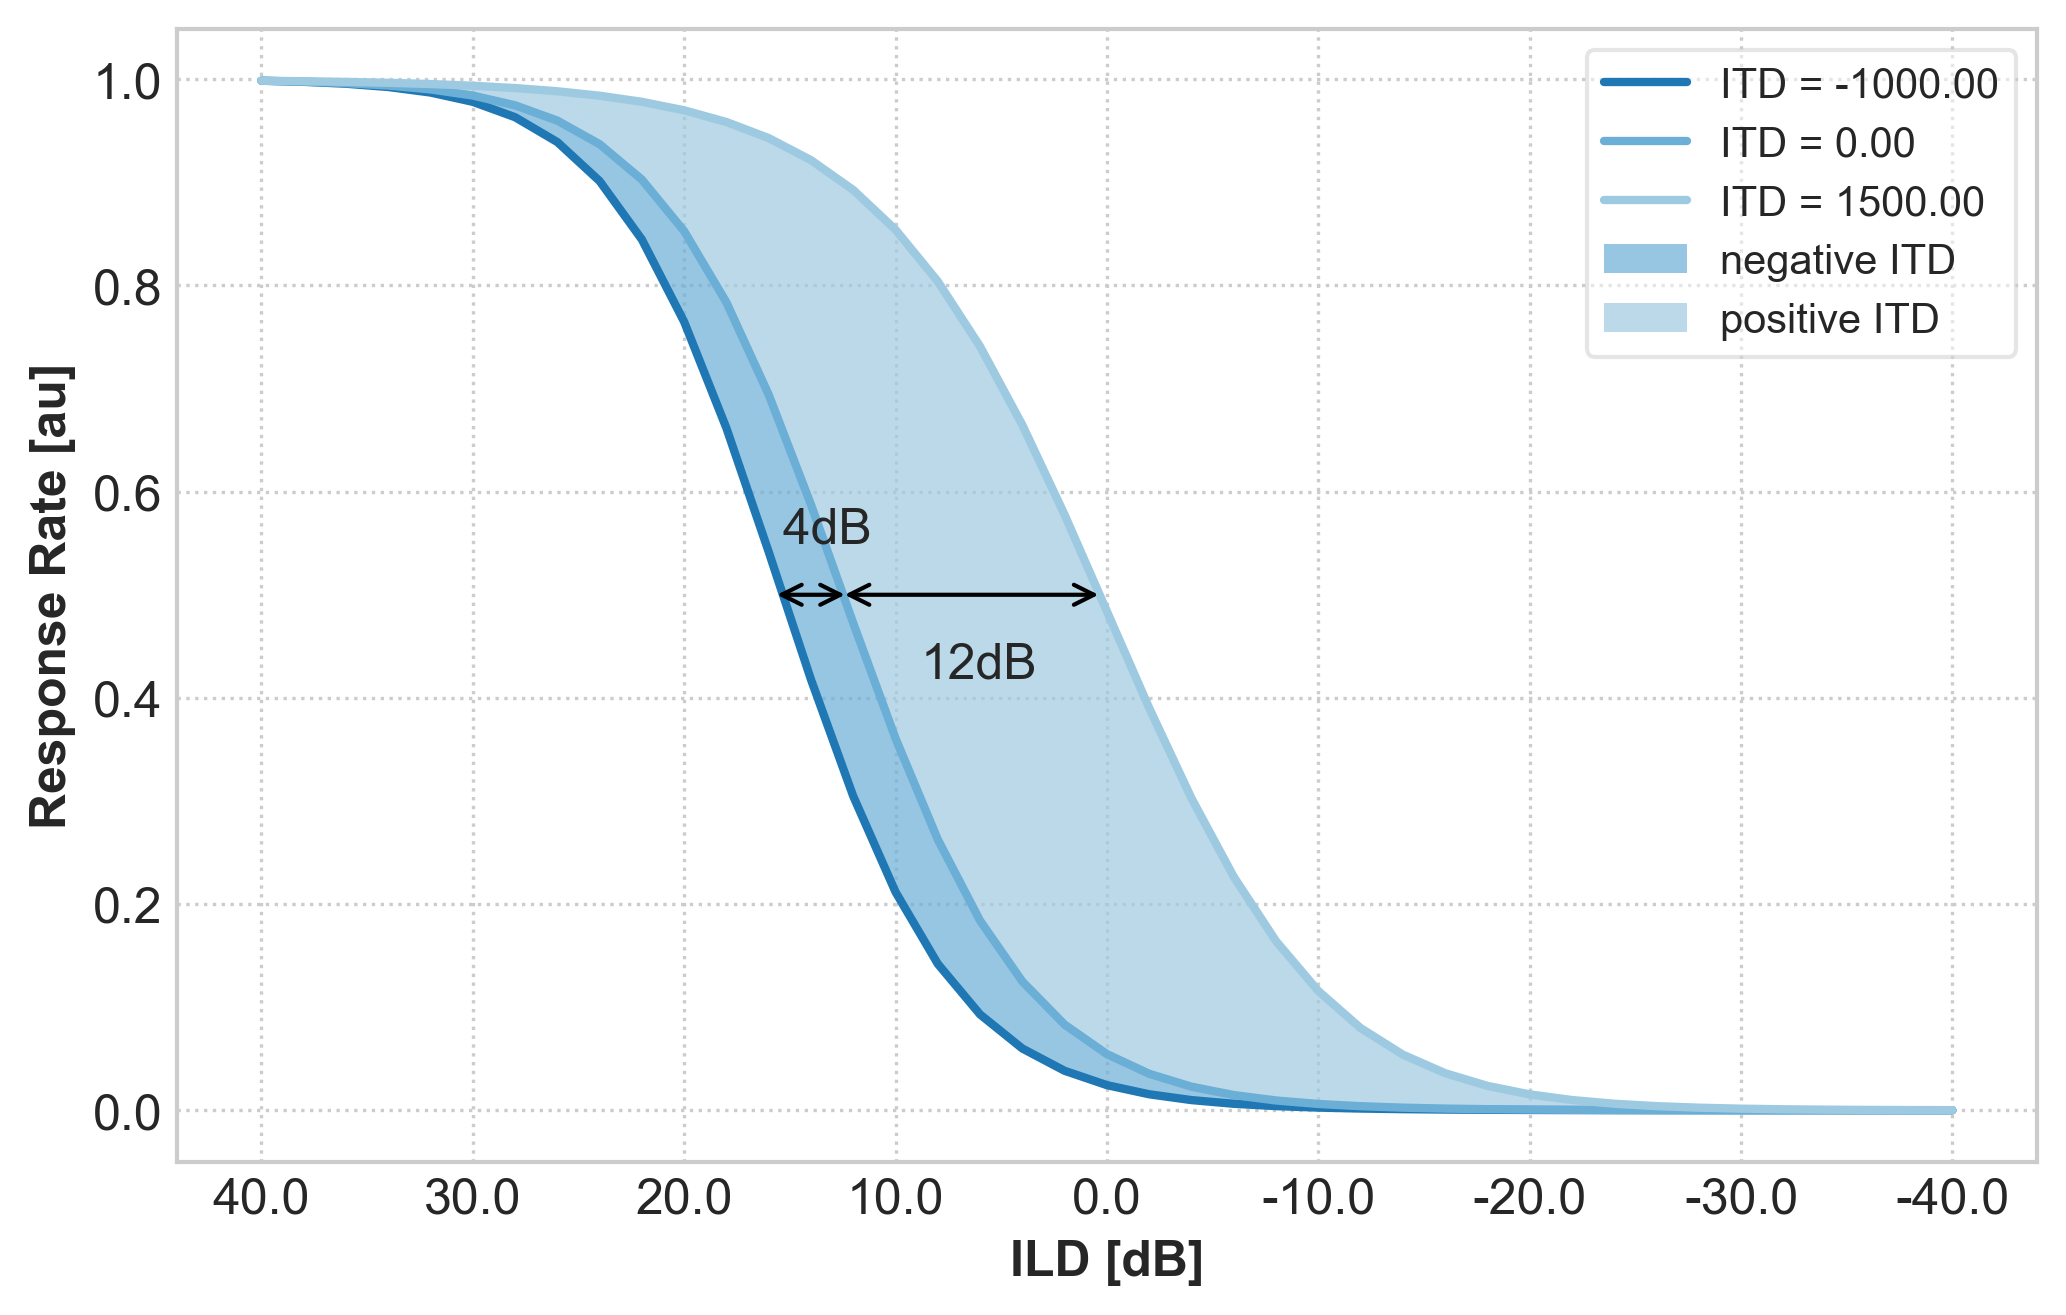

In [129]:
fig = plt.figure()

# probing_time = 1200
r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)

lower_bound = 60
zero_bound = 80
higher_bound = 110

    
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[lower_bound,:,probing_time],linestyle='-',color = 'C0',label='ITD = {0:.2f}'.format(gbc_offsets[lower_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],linestyle='-',color = '#6baed6',label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[higher_bound,:,probing_time],linestyle='-',color = '#9ecae1',label='ITD = {0:.2f}'.format(gbc_offsets[higher_bound]*10))

ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[lower_bound,:,probing_time], r[zero_bound,:,probing_time], facecolor='#6baed6', alpha=0.7,label='negative ITD')
ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[zero_bound,:,probing_time], r[higher_bound,:,probing_time], facecolor='#9ecae1', alpha=0.7,label='positive ITD')



x1 = diff[np.argmax(-np.gradient(r[lower_bound,:,probing_time]))]
x2 = diff[np.argmax(-np.gradient(r[zero_bound,:,probing_time]))]
x3 = diff[np.argmax(-np.gradient(r[higher_bound,:,probing_time]))]


ax1.annotate("", xy=(x2+0.02, 0.5), xytext=(x3, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax1.annotate("{0:2.0f}dB".format((x2-x3)*40), xy=(0,0), xytext=(0.22,0.42))

ax1.annotate("", xy=(x1, 0.5), xytext=(x2, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax1.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=(0,0), xytext=(0.40,0.55))


ax1.set_xticklabels(ax1.get_xticks()*-1)
# plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ILD [dB]')
l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
lgd = plt.legend()

plt.savefig(figure_name + 'ild_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

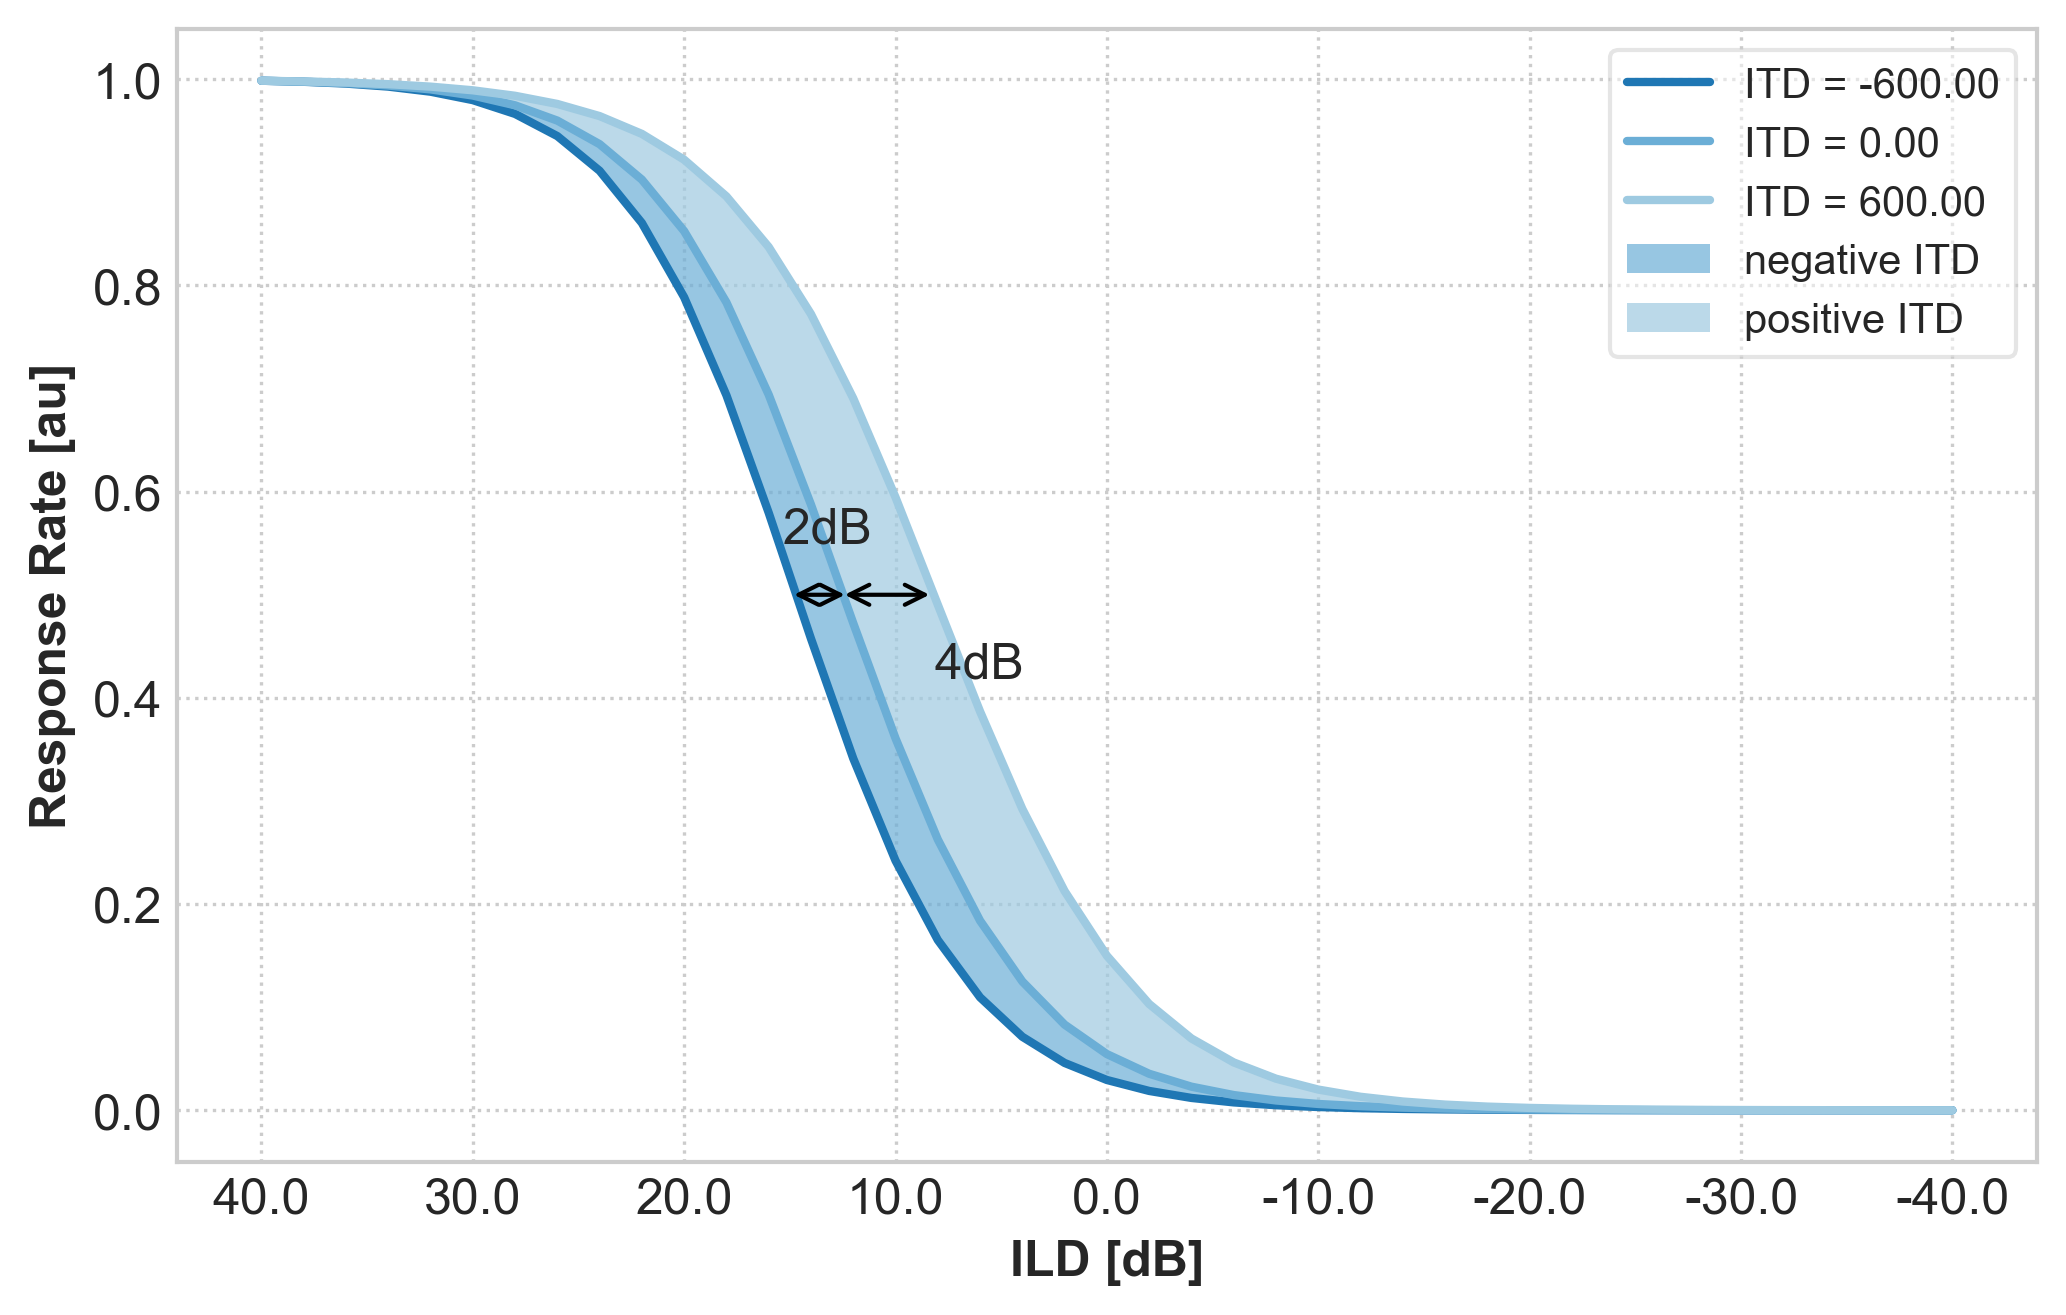

In [133]:
fig = plt.figure()

# probing_time = 1200
r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)

    
lower_bound = 68
zero_bound = 80
higher_bound = 92

    
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[lower_bound,:,probing_time],linestyle='-',color = 'C0',label='ITD = {0:.2f}'.format(gbc_offsets[lower_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],linestyle='-',color = '#6baed6',label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[higher_bound,:,probing_time],linestyle='-',color = '#9ecae1',label='ITD = {0:.2f}'.format(gbc_offsets[higher_bound]*10))

ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[lower_bound,:,probing_time], r[zero_bound,:,probing_time], facecolor='#6baed6', alpha=0.7,label='negative ITD')
ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[zero_bound,:,probing_time], r[higher_bound,:,probing_time], facecolor='#9ecae1', alpha=0.7,label='positive ITD')



x1 = diff[np.argmax(-np.gradient(r[lower_bound,:,probing_time]))]
x2 = diff[np.argmax(-np.gradient(r[zero_bound,:,probing_time]))]
x3 = diff[np.argmax(-np.gradient(r[higher_bound,:,probing_time]))]


ax1.annotate("", xy=(x2+0.02, 0.5), xytext=(x3, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax1.annotate("{0:2.0f}dB".format((x2-x3)*40), xy=(0,0), xytext=(0.22,0.42))

ax1.annotate("", xy=(x1+0.03, 0.5), xytext=(x2, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax1.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=(0,0), xytext=(0.40,0.55))


ax1.set_xticklabels(ax1.get_xticks()*-1)
# plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ILD [dB]')
l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
lgd = plt.legend()

plt.savefig(figure_name + 'ild_nicer_new_range.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer_new_range.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer_new_range.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

0.07340436808347645


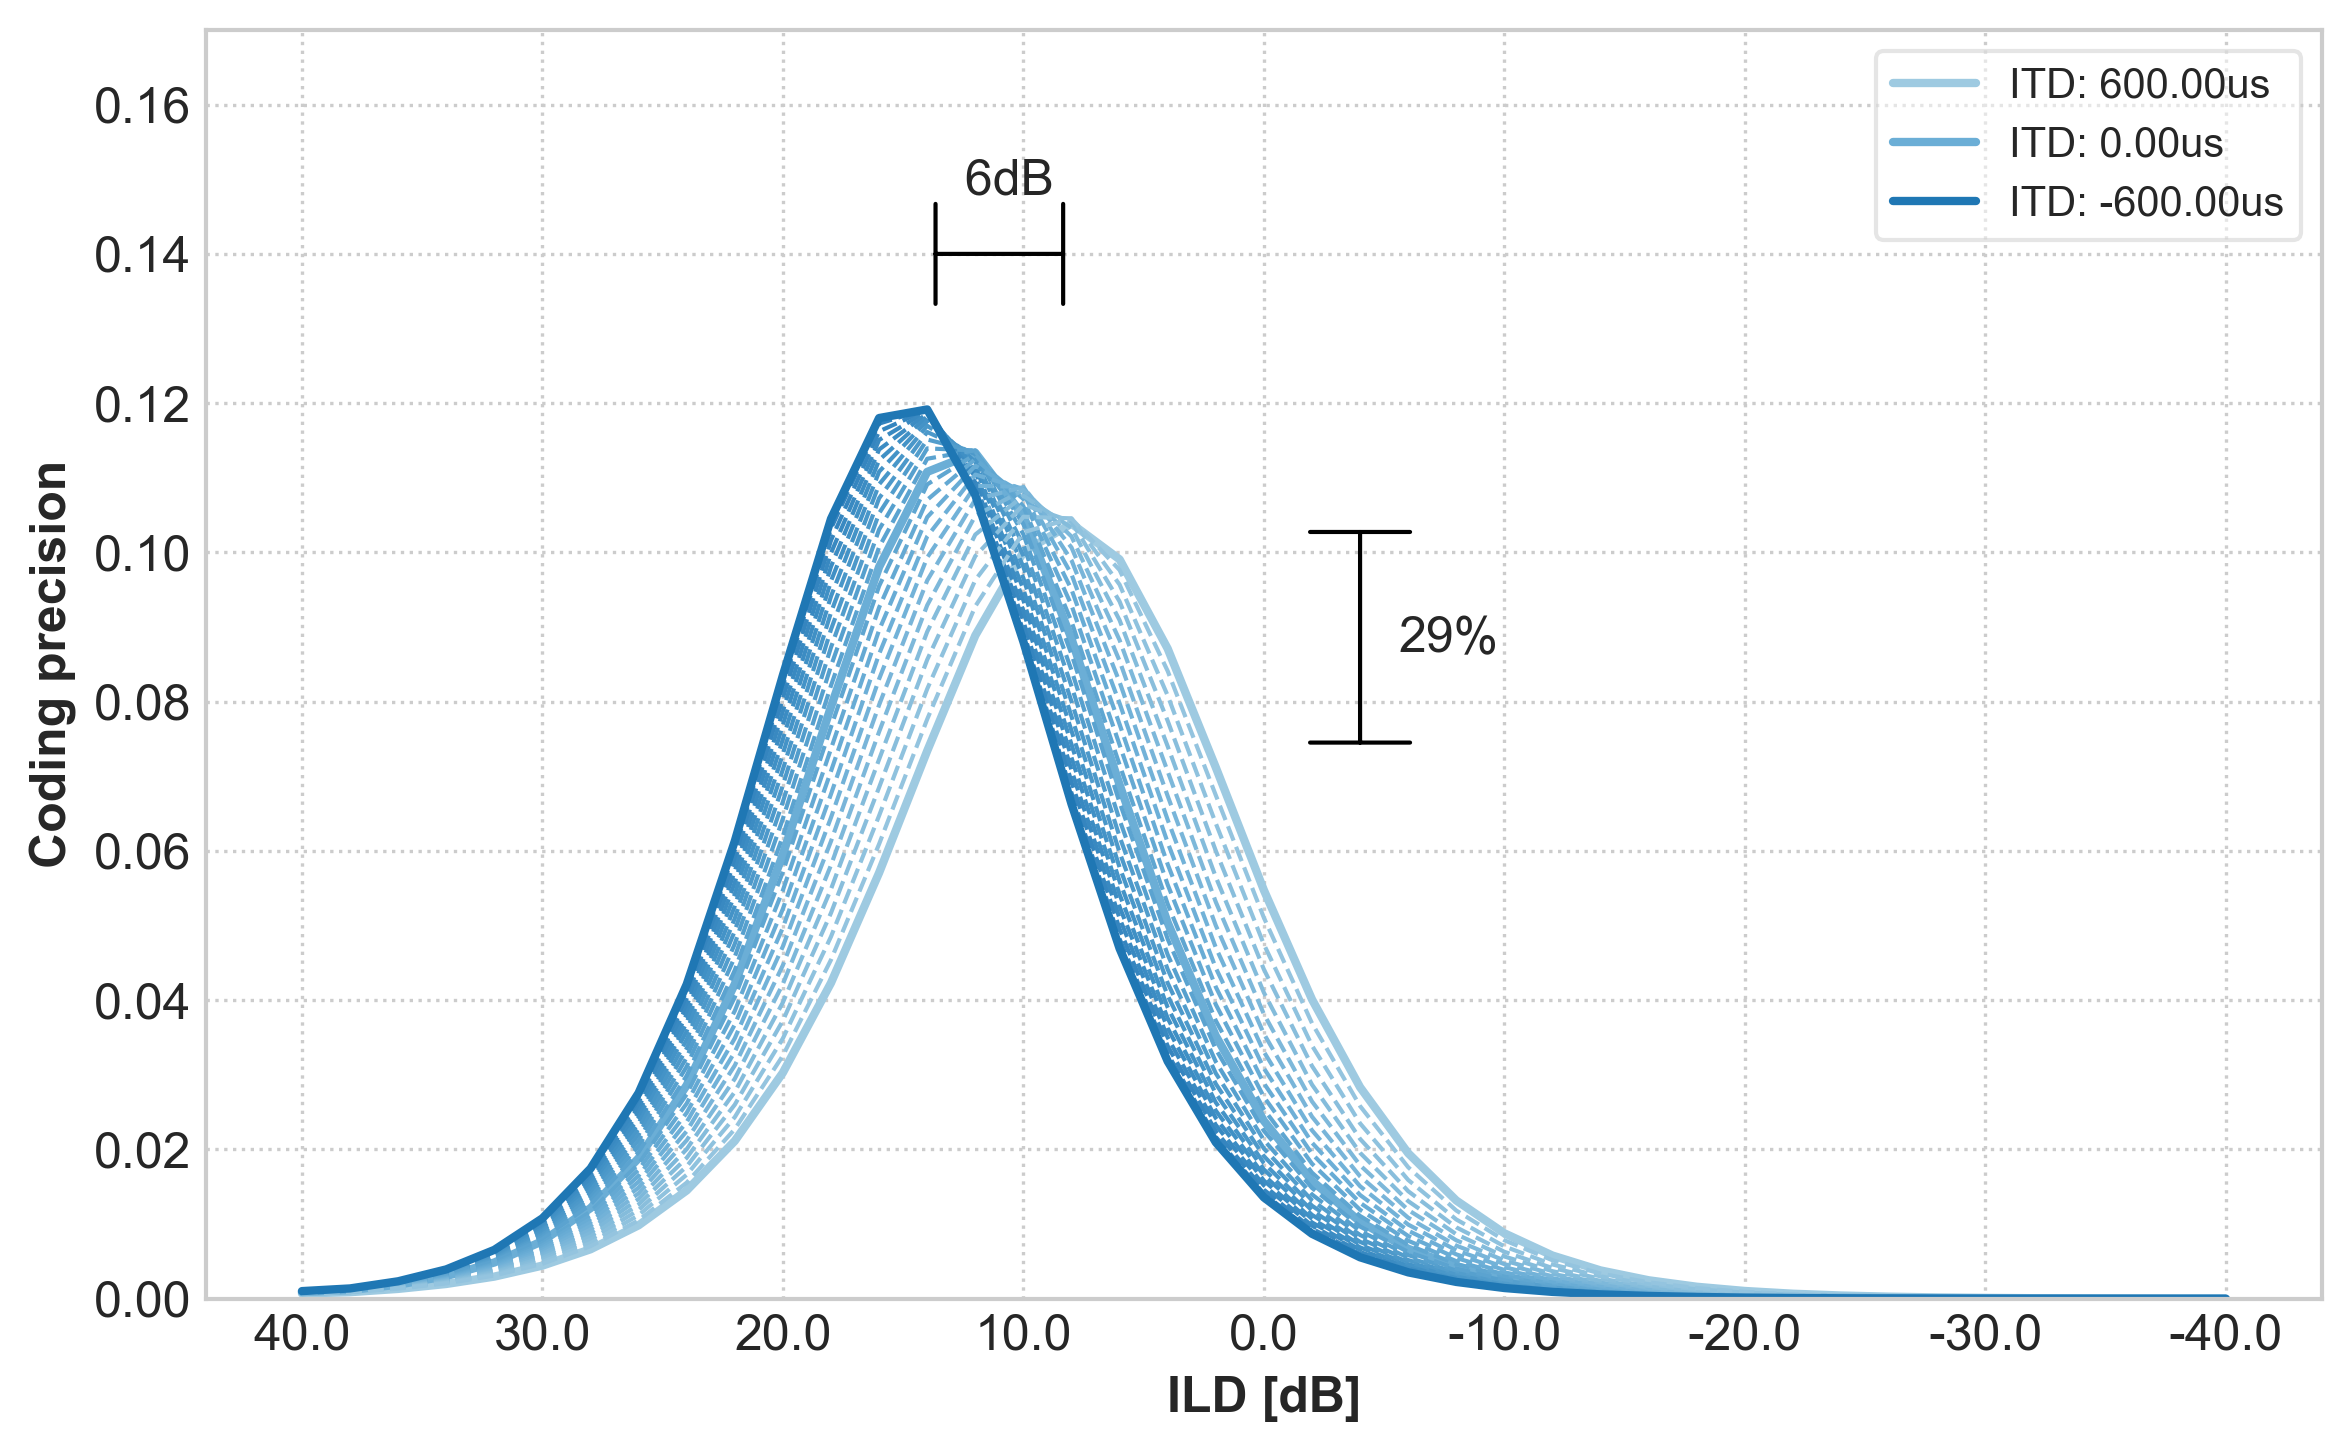

In [117]:
# probing_time = 1230

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
## show LSO neuron response

## show LSO neuron response
# fig = plt.figure()
# ax2 = fig.add_subplot(111)
# ilds = np.zeros((len(range(28,r.shape[0]-10,2)),len(r[0,:,probing_time])))
plotting_range = np.arange(68,80,1)
plotting_range = np.concatenate([plotting_range,np.arange(81,92,1)])
ilds = np.zeros((len(plotting_range),r.shape[1]))
# for i in range(r.shape[0]):
for i in range(len(plotting_range)):
    ilds[i,:] = r[plotting_range[i],:,probing_time]

diff = sbc_input_intensities-gbc_input_intensities
# colors = plt.cm.Blues(np.linspace(0.0,0.99,ilds.shape[0]))
# ax2.set_prop_cycle('color', colors)
# ax2.plot(diff,ilds.T)
# ax2.invert_xaxis()
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# plt.title('ILD')
#normalize it
ilds /= np.max(ilds.flatten())

# fig = plt.figure()
# fig = plt.figure(figsize=(8,3),dpi=72)
fig = plt.figure()

# mpl.rcParams.update({'font.size': 12,'figure.titlesize':12,'axes.labelsize':12,'axes.titlesize':12,'legend.fontsize':12})


## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.7,0.40,ilds.shape[0]))
ax2.set_prop_cycle('color', colors)

#######
# DIFF
#######
# tmp =-np.diff(ilds)
# ax2.plot(diff[:-1],tmp.T,linewidth = int(drawing_size/9),linestyle=':')

# # plot 0 ITD,
# ax2.plot(diff[:-1],-np.diff(r[80,:,probing_time]),linestyle='-',color = '#9ecae1',label='ITD = {0:.2f}'.format(gbc_offsets[80]*10))

# ax2.plot(diff[:-1],-np.diff(r[68,:,probing_time]),linestyle='-',color = '#6baed6',label='ITD = {0:.2f}'.format(gbc_offsets[68]*10))

# ax2.plot(diff[:-1],-np.diff(r[48,:,probing_time]),linestyle='-',color = 'C0',label='ITD = {0:.2f}'.format(gbc_offsets[48]*10))

# # calculate x value for first peak
# x1 = diff[np.argmax(-np.diff(r[48,:,probing_time]))]
# x2 = diff[np.argmax(-np.diff(r[80,:,probing_time]))]
# ax2.annotate("", xy=(x2, 0.23), xytext=(x1, 0.23),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}dB".format((x1-x2)*100), xy=((x1-x2)/2 -x2, 0.236), xytext=((x1-x2)/2 -x2-0.05, 0.236))


###########
# GRADIENT
###########

tmp =-np.array( np.gradient(ilds,axis=1))


# plot 0 ITD,
ax2.plot(diff,-np.gradient(r[92,:,probing_time]),linestyle='-',color = '#9ecae1',label='ITD: {0:.2f}us'.format(gbc_offsets[92]*10))

ax2.plot(diff,-np.gradient(r[80,:,probing_time]),linestyle='-',color = '#6baed6',label='ITD: {0:.2f}us'.format(gbc_offsets[80]*10))

ax2.plot(diff,tmp.T,linewidth = int(drawing_size/9),linestyle='--')

ax2.plot(diff,-np.gradient(r[68,:,probing_time]),linestyle='-',color = 'C0',label='ITD: {0:.2f}us'.format(gbc_offsets[68]*10))




# # calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(r[68,:,probing_time]))]
x2 = diff[np.argmax(-np.gradient(r[92,:,probing_time]))]
ax2.annotate("", xy=(x2, 0.14), xytext=(x1, 0.14),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x1-x2)/2 +x2, 0.148), xytext=((x1-x2)/2 +x2+0.05, 0.148))


# y1 = np.max(-np.gradient(r[68,:,probing_time]))
y1 = np.max(-np.gradient(r[92,:,probing_time]))

y1_ind = np.argmax(-np.gradient(r[68,:,probing_time]))
y2 = -np.gradient(r[92,:,probing_time])[y1_ind]
print(y2)
ax2.annotate("", xy=(-0.1, y1), xytext=(-0.1, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(-0.14, y2+(y1-y2)/2), xytext=(-0.14,  y2+(y1-y2)/2 -0.002))

# ax2.set_xticks(np.linspace(-1.0,1,9))
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.17])
# ax2.set_xlim([1,-1])
ax2.legend()
# plt.title('Coding Precision')

plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision_smaller_range.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision_smaller_range.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision_smaller_range.tiff', bbox_inches='tight')

plt.show()

0.01849984596186638


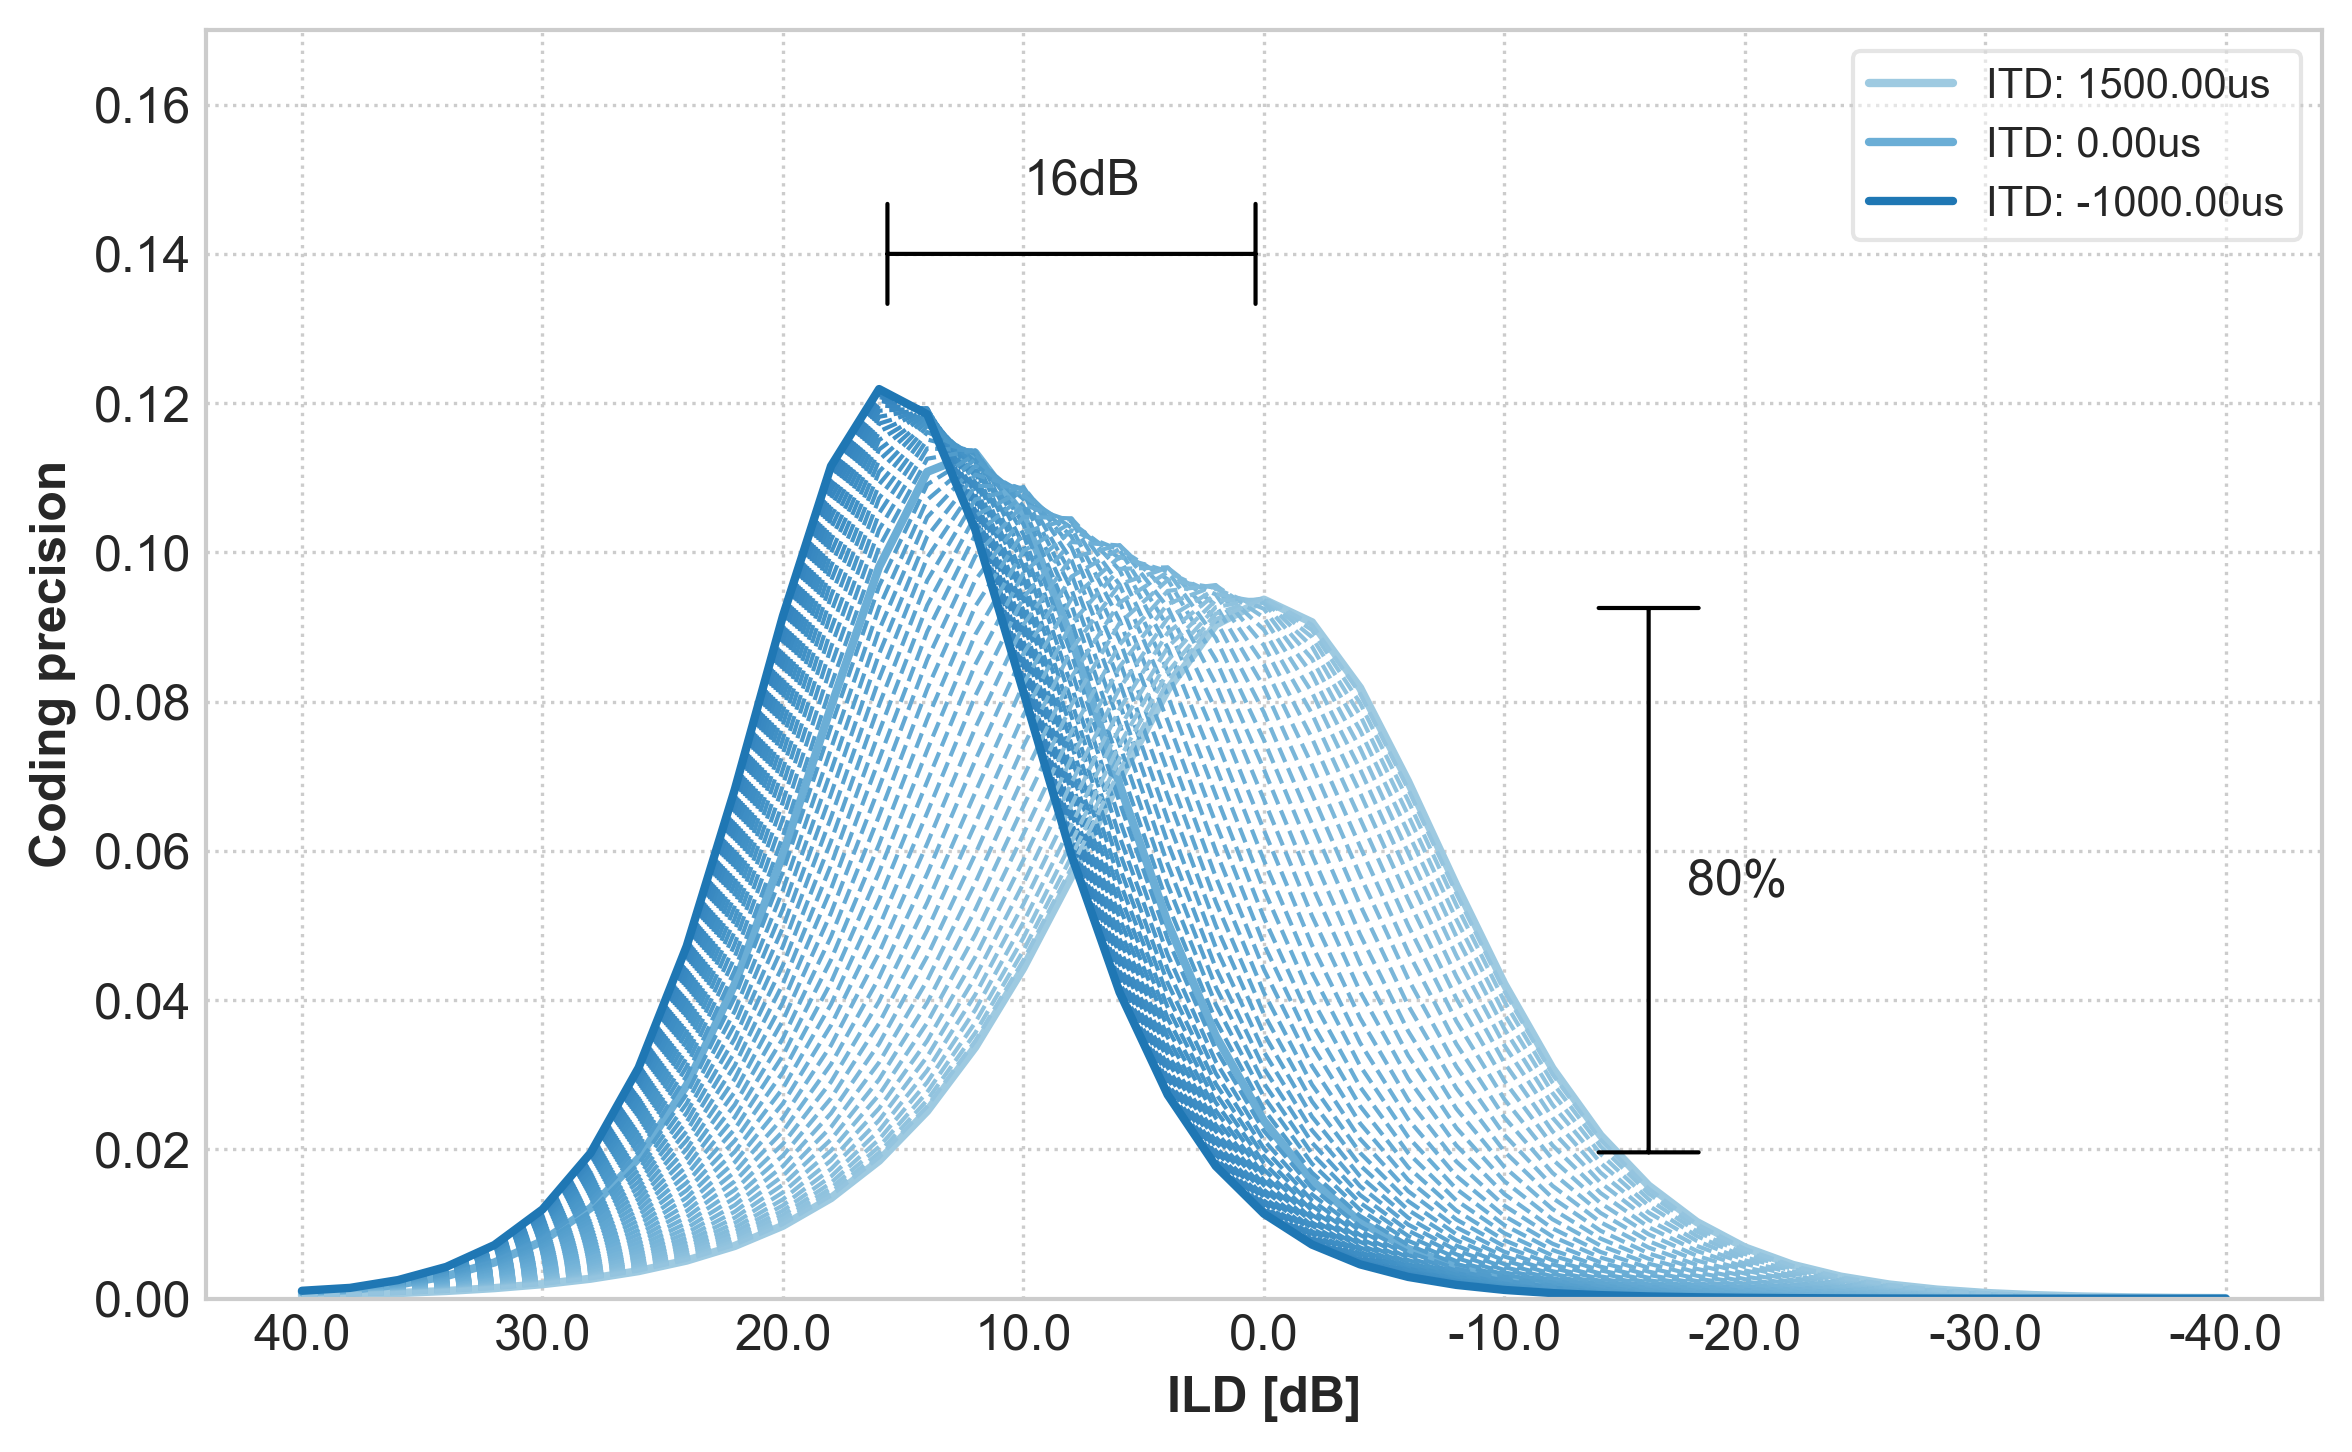

In [118]:
# probing_time = 1230

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
## show LSO neuron response

## show LSO neuron response
# fig = plt.figure()
# ax2 = fig.add_subplot(111)
# ilds = np.zeros((len(range(28,r.shape[0]-10,2)),len(r[0,:,probing_time])))
plotting_range = np.arange(60,80,1)
plotting_range = np.concatenate([plotting_range,np.arange(81,110,1)])
ilds = np.zeros((len(plotting_range),r.shape[1]))
# for i in range(r.shape[0]):
for i in range(len(plotting_range)):
    ilds[i,:] = r[plotting_range[i],:,probing_time]

diff = sbc_input_intensities-gbc_input_intensities
# colors = plt.cm.Blues(np.linspace(0.0,0.99,ilds.shape[0]))
# ax2.set_prop_cycle('color', colors)
# ax2.plot(diff,ilds.T)
# ax2.invert_xaxis()
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# plt.title('ILD')
#normalize it
ilds /= np.max(ilds.flatten())

# fig = plt.figure()
# fig = plt.figure(figsize=(8,3),dpi=72)
fig = plt.figure()

# mpl.rcParams.update({'font.size': 12,'figure.titlesize':12,'axes.labelsize':12,'axes.titlesize':12,'legend.fontsize':12})


## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.7,0.40,ilds.shape[0]))
ax2.set_prop_cycle('color', colors)

#######
# DIFF
#######
# tmp =-np.diff(ilds)
# ax2.plot(diff[:-1],tmp.T,linewidth = int(drawing_size/9),linestyle=':')

# # plot 0 ITD,
# ax2.plot(diff[:-1],-np.diff(r[80,:,probing_time]),linestyle='-',color = '#9ecae1',label='ITD = {0:.2f}'.format(gbc_offsets[80]*10))

# ax2.plot(diff[:-1],-np.diff(r[68,:,probing_time]),linestyle='-',color = '#6baed6',label='ITD = {0:.2f}'.format(gbc_offsets[68]*10))

# ax2.plot(diff[:-1],-np.diff(r[48,:,probing_time]),linestyle='-',color = 'C0',label='ITD = {0:.2f}'.format(gbc_offsets[48]*10))

# # calculate x value for first peak
# x1 = diff[np.argmax(-np.diff(r[48,:,probing_time]))]
# x2 = diff[np.argmax(-np.diff(r[80,:,probing_time]))]
# ax2.annotate("", xy=(x2, 0.23), xytext=(x1, 0.23),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}dB".format((x1-x2)*100), xy=((x1-x2)/2 -x2, 0.236), xytext=((x1-x2)/2 -x2-0.05, 0.236))


###########
# GRADIENT
###########

tmp =-np.array( np.gradient(ilds,axis=1))


# plot 0 ITD,
ax2.plot(diff,-np.gradient(r[110,:,probing_time]),linestyle='-',color = '#9ecae1',label='ITD: {0:.2f}us'.format(gbc_offsets[110]*10))

ax2.plot(diff,-np.gradient(r[80,:,probing_time]),linestyle='-',color = '#6baed6',label='ITD: {0:.2f}us'.format(gbc_offsets[80]*10))

ax2.plot(diff,tmp.T,linewidth = int(drawing_size/9),linestyle='--')

ax2.plot(diff,-np.gradient(r[60,:,probing_time]),linestyle='-',color = 'C0',label='ITD: {0:.2f}us'.format(gbc_offsets[60]*10))




# # calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(r[60,:,probing_time]))]
x2 = diff[np.argmax(-np.gradient(r[110,:,probing_time]))]
ax2.annotate("", xy=(x2, 0.14), xytext=(x1, 0.14),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x1-x2)/2 +x2, 0.148), xytext=((x1-x2)/2 +x2+0.05, 0.148))


# y1 = np.max(-np.gradient(r[68,:,probing_time]))
y1 = np.max(-np.gradient(r[110,:,probing_time]))

y1_ind = np.argmax(-np.gradient(r[60,:,probing_time]))
y2 = -np.gradient(r[110,:,probing_time])[y1_ind]
print(y2)
ax2.annotate("", xy=(-0.4, y1), xytext=(-0.4, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(-0.44, y2+(y1-y2)/2), xytext=(-0.44,  y2+(y1-y2)/2 -0.002))

# ax2.set_xticks(np.linspace(-1.0,1,9))
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.17])
# ax2.set_xlim([1,-1])
ax2.legend()
# plt.title('Coding Precision')

plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.tiff', bbox_inches='tight')

plt.show()

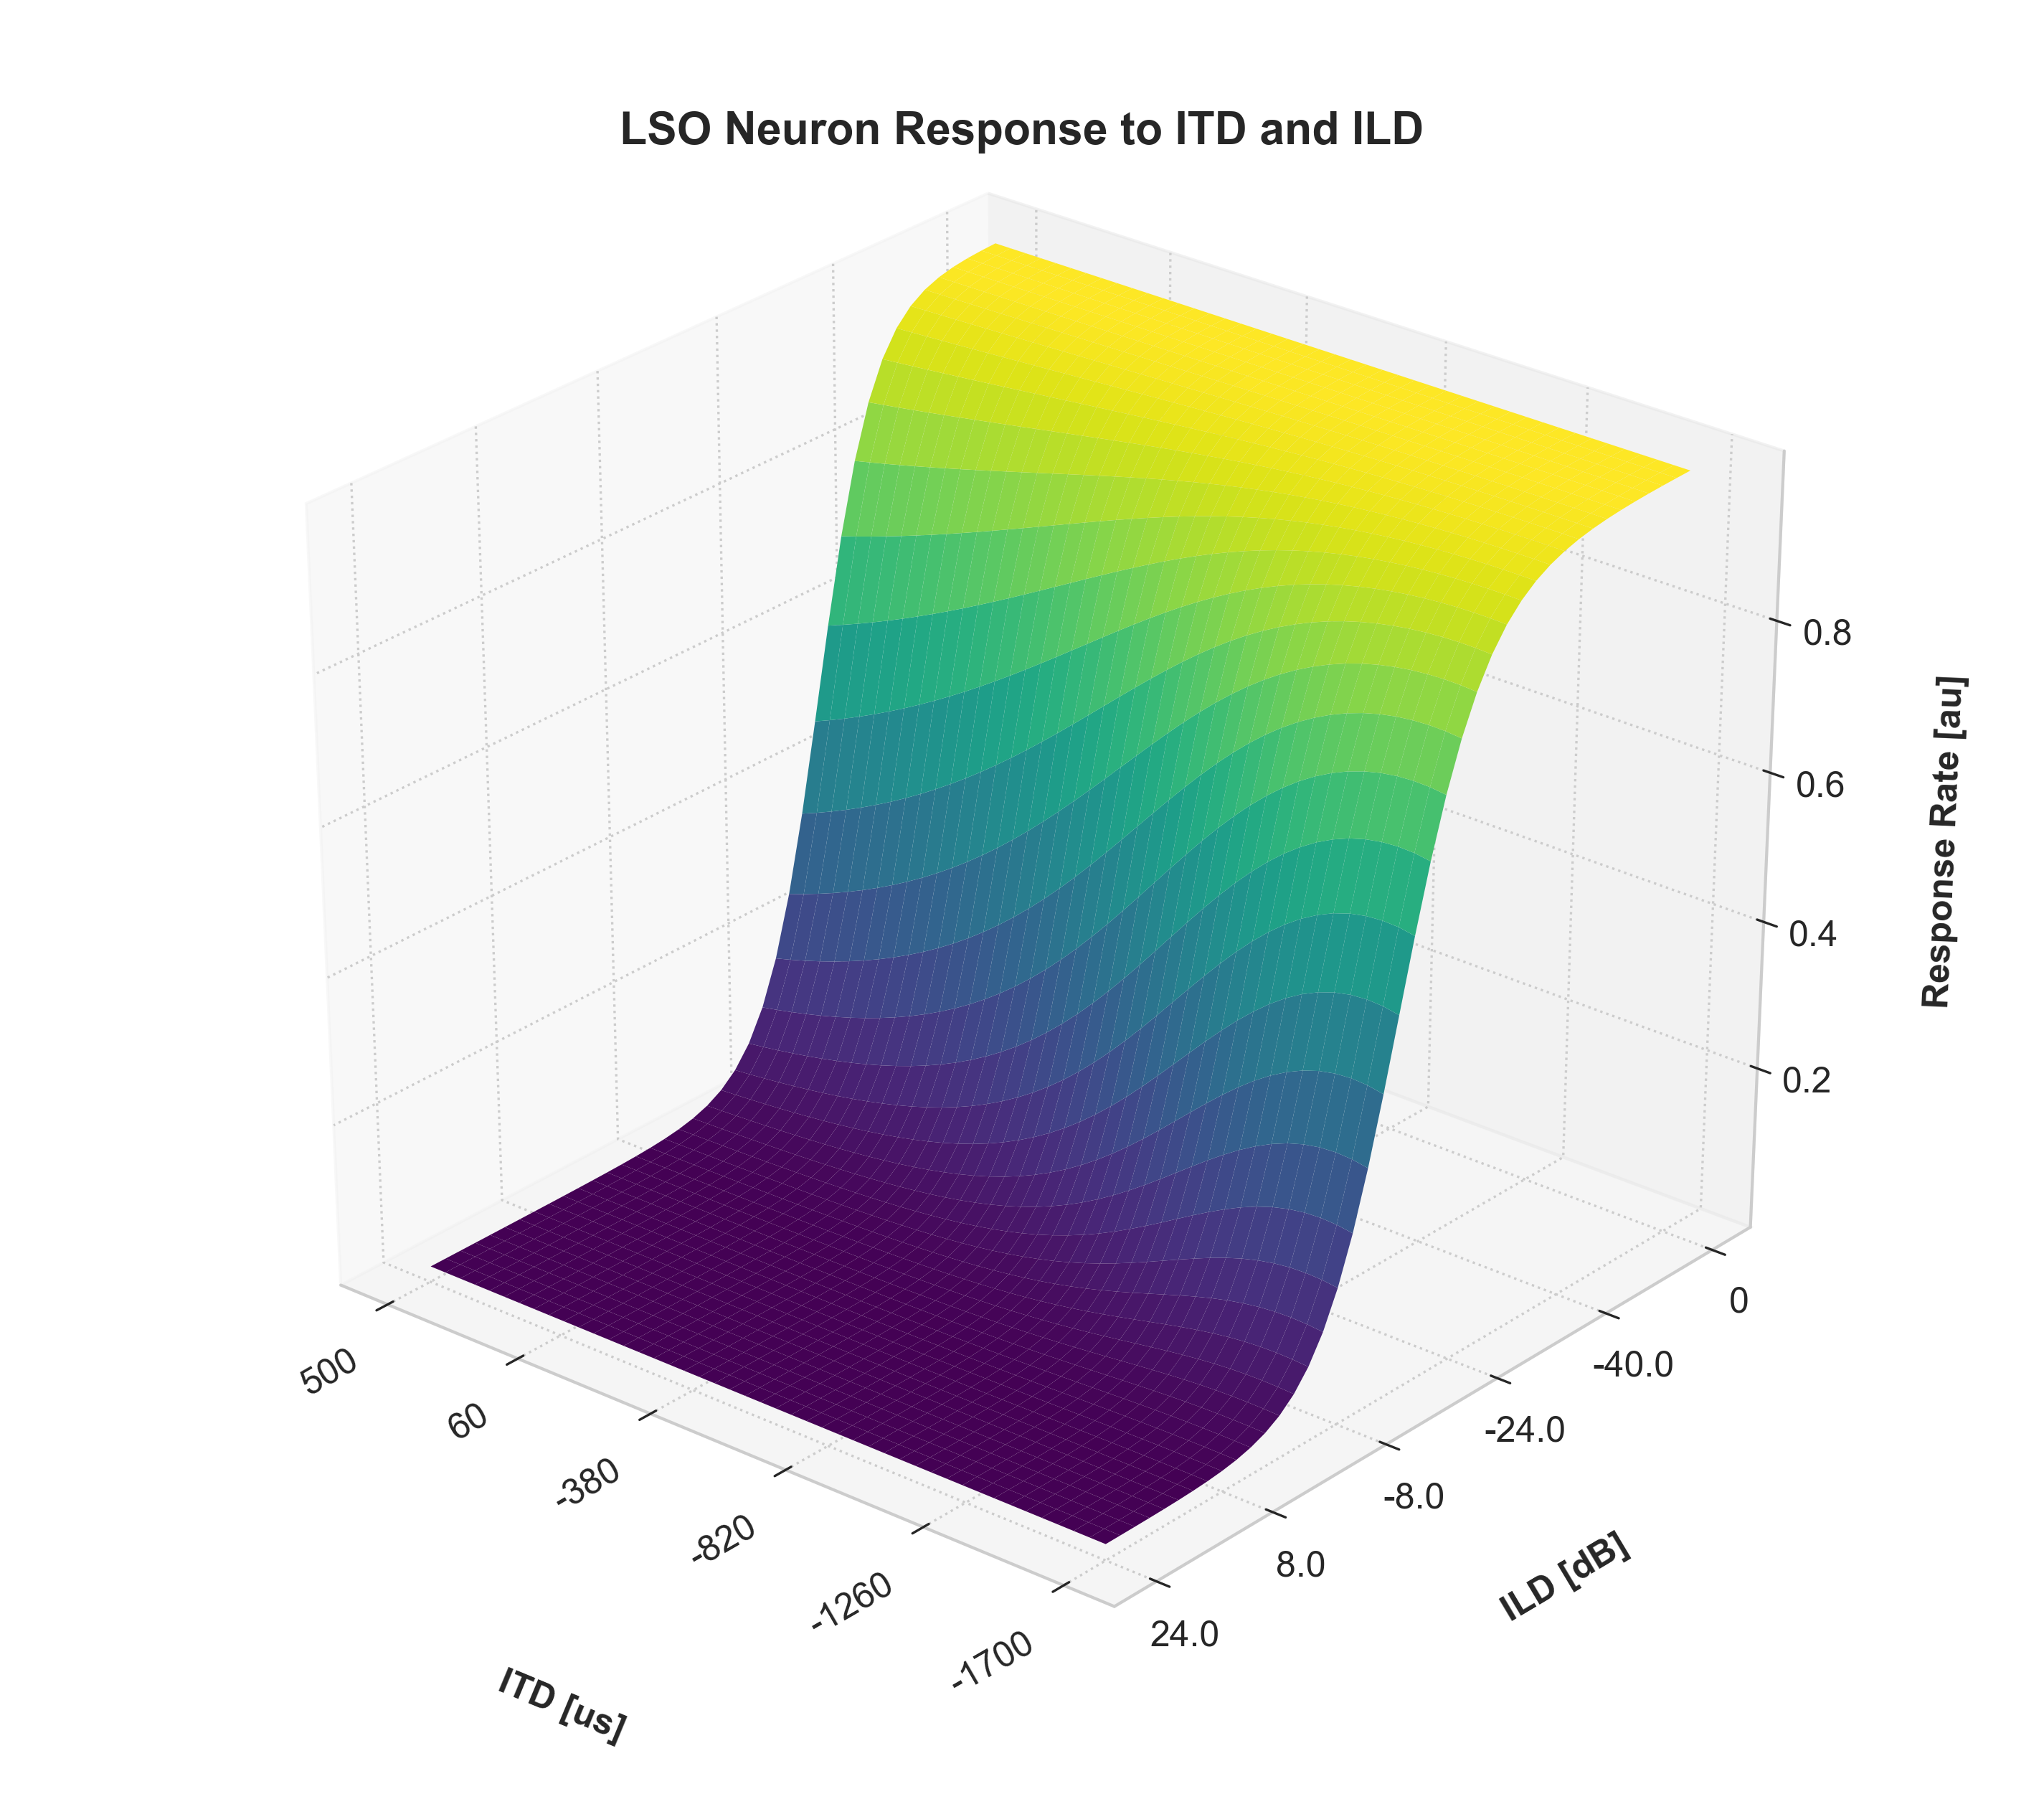

In [99]:
# fig = plt.figure(figsize=(20,20))
# ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()


fig = plt.figure(figsize=(12,12))

used_delay_ind = np.arange(70,115)

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]

ax1 = fig.add_subplot(111,projection='3d')

mesh_plot(r[used_delay_ind,:,probing_time],ax1)

# 0 ILD line
# zero_ild_plot_values = np.mean([r[used_delay_ind,10,probing_time],r[used_delay_ind,9,probing_time]],0)
# data = r[used_delay_ind,:,probing_time]
# x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), x.shape[0])
# ax1.plot(x,np.zeros(x.shape)+0.5,zero_ild_plot_values,color= 'C0',linewidth=2,label='ILD = {0:.1f}'.format(0.0))




ax1.view_init(elev=30., azim=-50)
ax1.dist = 11
plt.title('LSO Neuron Response to ITD and ILD')
ax1.set_zlabel('Response Rate [au]')

ild_ticks = gbc_input_intensities-sbc_input_intensities
ild_ticks = np.linspace(np.min(ild_ticks),np.max(ild_ticks),len(ax1.get_yticks())-2)
ax1.set_yticklabels(['{0:.0f}'.format(-i*100) for i in ild_ticks])
l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_yticklabels())-2))
ax1.set_yticklabels(l)

plt.ylabel('ILD [dB]')

itd_ticks = gbc_offsets[used_delay_ind]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_xticks())-2)
ax1.set_xticklabels(['{0:.0f}'.format(-i*10) for i in itd_ticks])
plt.xlabel('ITD [us]')

plt.gca().invert_yaxis()

# create 0 ITD line
# data = r[used_delay_ind,:,500]
# x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
# y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
# # x = np.linspace(0, 1, data.shape[0])
# # y = np.linspace(0, 1, data.shape[1])
# x, y = np.meshgrid(x, y)
# lines = np.arange(12,13)
# cset = ax1.plot_wireframe(x[:,lines],y[:,lines]+0.1,data.T[:,lines]+0.1)

ax1.yaxis.labelpad=30
ax1.xaxis.labelpad=55
ax1.zaxis.labelpad=20

fig.autofmt_xdate()

# plt.savefig(figure_name + 'receptive_field_3d.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'receptive_field_3d.pdf', bbox_inches='tight')

# plt.tight_layout()

plt.show()






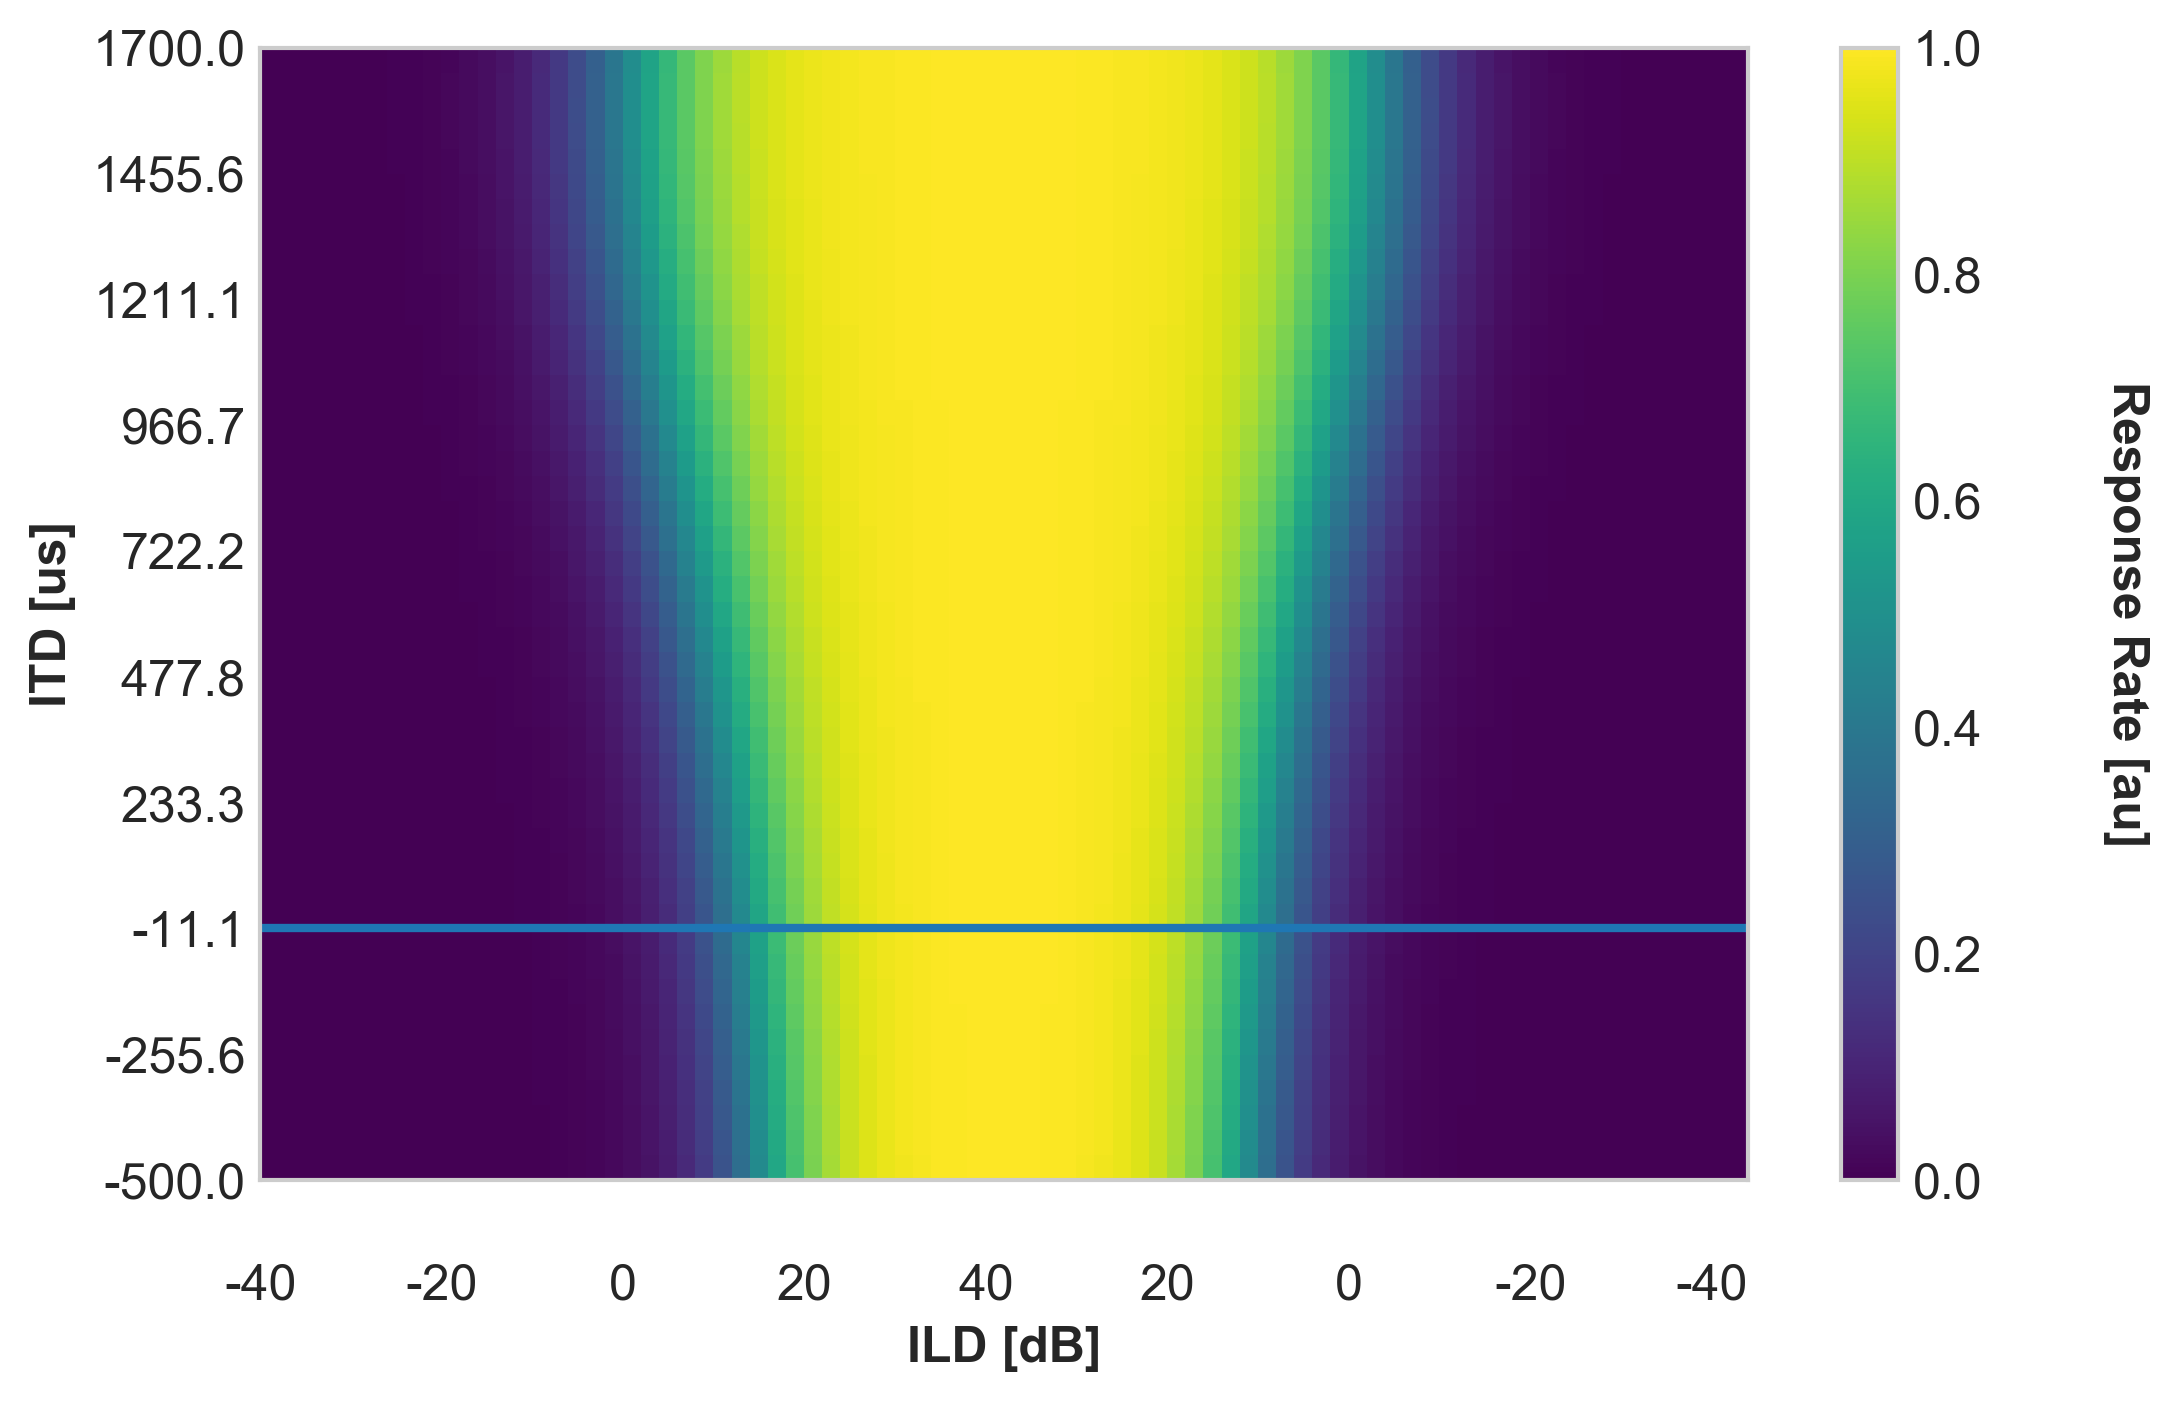

In [104]:
fig = plt.figure()


r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]

tmp = r[used_delay_ind,:,probing_time]
tmp2 = r[used_delay_ind,:,probing_time]

mirrord_rf = np.concatenate([np.flip(tmp,1),tmp2],1)

ax1 = fig.add_subplot(111)

c = ax1.pcolormesh(mirrord_rf,cmap="viridis",linewidth=0,rasterized=True,vmin=0., vmax=1.)

# add a horizontal lone 
ax1.hlines(10,0,82,color='C0',linestyle='-')

plt.xlabel('ILD [dB]')
plt.ylabel('ITD [us]')
# plt.title('LSO Receptive Field')
cbar = plt.colorbar(c)
cbar.set_label('Response Rate [au]', rotation=270, labelpad=40,)

ild_ticks = np.linspace(-0.4,0.4,int(len(ax1.get_xticks())/2))[:-1]
ild_ticks_inverse = ild_ticks[::-1]
ild_ticks = np.concatenate([ild_ticks,[0.4],ild_ticks_inverse])

ax1.set_xticklabels(['{0:.0f}'.format(i*100) for i in ild_ticks])

itd_ticks = gbc_offsets[used_delay_ind]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_yticks()))
ax1.set_yticklabels(['{0:.1f}'.format(i*10) for i in itd_ticks])

# set ticks a bit down
for tick in ax1.get_xaxis().get_major_ticks():
    tick.set_pad(20.)
    tick.label1 = tick._get_text1()

plt.savefig(figure_name + 'receptive_field_2d.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'receptive_field_2d.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'receptive_field_2d.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.tight_layout()
plt.show()

In [20]:
# # probing_time = 1600

# r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
# q = q_all[:,:,:,sbc_center_frequencyBand]
# ## show LSO neuron response

# ## show LSO neuron response
# # fig = plt.figure()
# # ax2 = fig.add_subplot(111)
# # ilds = np.zeros((len(range(28,r.shape[0]-10,2)),len(r[0,:,probing_time])))
# plotting_range = np.arange(60,80,1)
# ilds = np.zeros((len(plotting_range),r.shape[1]))
# # for i in range(r.shape[0]):
# for i in range(len(plotting_range)):
#     ilds[i,:] = r[plotting_range[i],:,probing_time]

# diff = sbc_input_intensities-gbc_input_intensities

# ilds /= np.max(ilds.flatten())

# # fig = plt.figure()

# ## show LSO neuron response
# # ax2 = fig.add_subplot(111)
# # colors = plt.cm.Blues(np.linspace(0.7,0.40,ilds.shape[0]))
# # ax2.set_prop_cycle('color', colors)



# tmp =-np.array( np.gradient(ilds,axis=1))


# # plot 0 ITD,

# # ax2.plot(diff,tmp.T,linewidth = int(drawing_size/9),linestyle='--')

# # # ax2.plot(diff[np.argmax(tmp.T,axis=0)],np.max(tmp.T,axis=0))
# # ax2.scatter(diff,np.max(tmp,axis=0))

# # ax2.set_xticks(np.linspace(-1.0,1,9))
# # ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# # ax2.set_ylabel('Separation')
# # ax2.set_xlabel('ILD [dB]')
# # ax2.invert_xaxis()
# # ax2.set_ylim([0,0.25])
# # # ax2.set_xlim([1,-1])
# # # ax2.legend()
# # plt.title('Coding Precision')

# # plt.tight_layout()

#  # saving:
# f = open("precision_maxima_timing.csv", "w")
# f.write("# x y\n")        # column names
# np.savetxt(f, np.array([diff, np.max(tmp,axis=0)]).T)
# # loading:
# x_timing, y_timing = np.loadtxt("precision_maxima_timing.csv", unpack=True)
# # x_gaba, y_gaba = np.loadtxt("precision_maxima_gaba_influence.csv", unpack=True)
# x_adaptation, y_adaptation = np.loadtxt("precision_maxima_adaptation.csv", unpack=True)



# fig = plt.figure()

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# ax2.plot(x_timing,y_timing,linestyle = ':')
# # ax2.plot(x_gaba,y_gaba)
# ax2.plot(x_adaptation,y_adaptation)
# ax2.set_ylim([0,0.17])
# ax2.set_xlim([1,-1])
# ax2.set_ylabel('Separation')
# ax2.set_xlabel('ILD [dB]')
# plt.show()

In [21]:
# # probing_time = 1700

# r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
# q = q_all[:,:,:,sbc_center_frequencyBand]
# ## show LSO neuron response

# ## show LSO neuron response
# fig = plt.figure()
# # ax2 = fig.add_subplot(111)
# # ilds = np.zeros((len(range(28,r.shape[0]-10,2)),len(r[0,:,probing_time])))
# plotting_range = np.arange(80,110,1)
# ilds = np.zeros((len(plotting_range),r.shape[1]))
# # for i in range(r.shape[0]):
# for i in range(len(plotting_range)):
#     ilds[i,:] = r[plotting_range[i],:,probing_time]

# diff = sbc_input_intensities-gbc_input_intensities

# ilds /= np.max(ilds.flatten())

# # fig = plt.figure()

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# colors = plt.cm.Blues(np.linspace(0.7,0.40,ilds.shape[0]))
# ax2.set_prop_cycle('color', colors)



# tmp = -np.array( np.gradient(ilds,axis=1))


# # plot 0 ITD,

# ax2.plot(diff,tmp.T,linewidth = int(drawing_size/9),linestyle='--')

# # ax2.plot(diff[np.argmax(tmp.T,axis=0)],np.max(tmp.T,axis=0))
# ax2.scatter(diff[np.argmax(tmp,axis=1)],np.max(tmp,axis=1))


# fit = np.polyfit(diff[np.argmax(tmp,axis=1)],np.max(tmp,axis=1),1)
# fit_fn = np.poly1d(fit) 
# print(tmp.shape)
# ax2.plot(diff[np.argmax(tmp,axis=1)],fit_fn(diff[np.argmax(tmp,axis=1)]),color= 'black', linestyle = '--')

# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_ylabel('Separation')
# ax2.set_xlabel('ILD [dB]')
# ax2.invert_xaxis()
# ax2.set_ylim([0,0.17])
# # ax2.set_xlim([1,-1])
# # ax2.legend()
# plt.title('Coding Precision')

# plt.tight_layout()

# #  # saving:
# # f = open("precision_maxima_timing.csv", "w")
# # f.write("# x y\n")        # column names
# # np.savetxt(f, np.array([diff, np.max(tmp,axis=0)]).T)
# # # loading:
# # x_timing, y_timing = np.loadtxt("precision_maxima_timing.csv", unpack=True)
# # # x_gaba, y_gaba = np.loadtxt("precision_maxima_gaba_influence.csv", unpack=True)
# # x_adaptation, y_adaptation = np.loadtxt("precision_maxima_adaptation.csv", unpack=True)



# # fig = plt.figure()

# # ## show LSO neuron response
# # ax2 = fig.add_subplot(111)
# # ax2.plot(x_timing,y_timing,linestyle = ':')
# # # ax2.plot(x_gaba,y_gaba)
# # ax2.plot(x_adaptation,y_adaptation)
# # ax2.set_ylim([0,0.17])
# # ax2.set_xlim([1,-1])
# # ax2.set_ylabel('Separation')
# # ax2.set_xlabel('ILD [dB]')
# # plt.show()